In [1]:
#Notations : p prime, MesF Mestre test function, fnu inertia degree, lam = lambda

#MesF : Mestre test function. For these algorithms to be correct, MesF must be 
# Complactly supported in [-1,1], even function, positive Fourier transform

Mes(x) = (1-x)*cos(pi*x)+sin(pi*x)/pi


def liste_premier_lambda(lam):                         # Input : lam 
    C = floor(exp(lam))                                # Output : List of primes <= exp(lam)
    return prime_range(C+1)


#Only over Q
def Mestre_somme_premier_lambda(p,lam,MesF):            #Local Mestre sum          
    S,m,x = 0,1,p                                       
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x *= x
        m += 1
    return numerical_approx(log(p)*S)


   
#Only works over Q.    
def Mestre_somme_lambda(lam,MesF):                        # Global Mestre sum 
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        Somme += (Mestre_somme_premier_lambda(p,lam,MesF)).numerical_approx()
    return 2*Somme                                        #In the final formula this sum must be multiplied by two

#Only work over Q                                           
def somme_mult_badprimes_lambda(p,lam,MesF):                 # Local sum in the case of p|N i.e multiplicative reduction      
    S = p^(-1)*MesF(math.log(p)/lam.numerical_approx())
    m = 2
    x = p^2
    while x <= exp(lam):
        S= (S + x^(-1)*MesF(m*math.log(p)/lam.numerical_approx())).numerical_approx()
        x= p * x
        m = m+1
    return numerical_approx(log(p)*S)

                                                              #Additive reduciton : the sum is 0 we don't code it


#Only over Q - uses the Wil bound
#input : lambda, MesF,two lists of bad primes : one for multiplicative red and one for additive red



def Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes): #Global sum with mult and add reductions
    Liste = liste_premier_lambda(lam)                                              
    Somme = 0
    for p in Liste:                                                  
        if p in mult_badprimes :                               #Correct sum for multiplicative red
            Somme += somme_mult_badprimes_lambda(p,lam,MesF)
        elif p in add_badprimes:
            Somme += 0                                         #Do nothing for additive reduction
        else:
            Somme += Mestre_somme_premier_lambda(p,lam,MesF)   # In case of good reduction
    return 2*Somme                                             #factor 2 in the final sum - present in Mestre explicit formula                                                           




#remark : the list we give in input are lists of primes CONTAINED in the set of primes of bad reduction.
#The algorithm stays worect if we forgot some primes of bad reduction, but the result is lee precise 
# that is to say the final bound is lwoer that it would be



#Function defining the integrals terms appearing. Not correct if MesF is not completly supported in [-1,1]


def Value_Phi_0(MesF):      #The integral term which will be multiplied by the rank. Fourier transform of MesF eval at 0
    return 2*numerical_integral(MesF(x),0,1)[0]


Constant_Mlambda = 2*math.log(2*pi)     #constant appearing in the formula, let's stock it



def Mlambda2(lam,MesF):
    aux(x) = MesF(x) * exp(-lam*x)/(1-exp(-lam*x)) - MesF(0) * exp(-lam*x)/(lam*x)
    a = numerical_integral(aux(x),0,1)[0]
    b = numerical_integral(exp(-x)/x, lam.numerical_approx() , Infinity )[0] #depends on lam, cannot be stocked :(
    return 2*(lam*a - MesF(0)*b) +   MesF(0)*Constant_Mlambda       #still a foctor two at the end, like the sum




#Final lower bound 

#Only over Q
def minorant_conducteur_lambda(lam,MesF,rk):      #Without knowing anything on the conductor
    K = lam * rk * Value_Phi_0(MesF)+Mlambda2(lam,MesF)-Mestre_somme_lambda(lam,MesF)
    return exp(K)

#Only over Q
def minorant_conducteur_lambda_withbadprimes(lam,MesF,rk,mult_badprimes,add_badprimes): #knowing some primes of add and mul reduction
    K = lam * rk *Value_Phi_0(MesF) + Mlambda2(lam,MesF)-Mestre_somme_withbadprimes_lambda(lam,MesF,mult_badprimes,add_badprimes)
    return exp(K)




In [2]:
#In number fields, without knowing anything about the bad primes, using only the Weil bound

def somme_premier_degre_ramifi(p,lam,MesF,fnu):
    q = p^fnu
    S,m,x = 0,1,q
    while x<= exp(lam):
        S += (floor(2*sqrt(x)) * x^(-1) * MesF(m*math.log(q)/lam.numerical_approx())).numerical_approx()
        x *=  q
        m +=  1
    return numerical_approx(log(q)*S)



def Mestre_somme_lambda_nbfield(lam,MesF,K):        #lam = lambda, MesF mestre test function, K number field            
    Liste = liste_premier_lambda(lam)
    Somme = 0
    for p in Liste:
        for pp in K.primes_above(p):
            fnu = pp.residue_class_degree()
            Somme += (somme_premier_degre_ramifi(p,lam,MesF,fnu)).numerical_approx()
    return 2 * Somme             # un facteur de 2 car deux termes conjugués dans la somme de Mestre



def minorant_conducteur_lambda_nbfield(lam,MesF,rk,K):     # K nb field (chose not to give polynomial in case of tower extension)  
    n = K.absolute_degree()
    disc = K.absolute_discriminant()
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) - Mestre_somme_lambda_nbfield(lam,MesF,K)
    return exp(lowbound)/(disc^2)




#With Frobenius

def Somme_Frob(p,fnu,lam,MesF,Frob):
    q = p^fnu 
    delt = Frob^2-4*q
    alpha = (Frob-I*sqrt(-delt))/2
    beta = (Frob+I*sqrt(-delt))/2
    a = alpha
    b = beta
    Somme = 0
    m = 1
    x = q
    while x <= exp(lam):
        Somme += (MesF(m*math.log(q)/numerical_approx(lam))*(a+b)/x).numerical_approx()   # compute the sum
        a     *= alpha                                             # powers of roots of Frob increment
        b     *= beta
        x     *= q                                                 # denominator of the sum increment
        m     += 1
    finalSomme = Somme * math.log(q)                           # factor  2 in the Mestre formula
    return numerical_approx(finalSomme)


def Mini_Somme_Frob(p,fnu,lam,MesF):       #take the minimal over all possible fors, return the frob and the sum 
    bound = floor(2*sqrt(p^fnu))
    MinFrob = - bound
    MinSomme = Somme_Frob(p,fnu,lam,MesF,MinFrob)
    for Frobenius in range(-bound+1,bound+1):
        C = Somme_Frob(p,fnu,lam,MesF,Frobenius)
        if C < MinSomme:
            MinFrob = Frobenius
            MinSomme = C
    return (MinFrob,MinSomme)


def Mestre_Somme_Frob(lam,MesF,K):
    Listeprime = liste_premier_lambda(lam)
    BigSomme = 0
    ListeFrob = []
    for p in Listeprime:
        for prims in K.primes_above(p):
            fnu = prims.residue_class_degree()
            print(p,fnu)
            frobenius,value = Mini_Somme_Frob(p,fnu,lam,MesF)
            BigSomme += value.numerical_approx()
            ListeFrob += [(p,fnu,frobenius)]
    return (ListeFrob,2*BigSomme)

def minorant_conducteur_nbfield_Frobenius(lam,MesF,rk,K):   # K nb field  
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Listefrobs, MestreSomme = Mestre_Somme_Frob(lam,MesF,K)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + MestreSomme
    return Listefrobs , exp(lowbound)/(discri^2)





def Somme_liste_Frob(lam,MesF,lisfrobs):   #Input: the list of primes considered, with their fnu and attributed frobenius
    S = 0
    for k in lisfrobs:
        p,fnu,Frob = k
        S += (Somme_Frob(p,fnu,lam,MesF,Frob)).numerical_approx()
    return S

def minorant_liste_Frob(lam,MesF,rk,K,lisfrobs):
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Mestresomme = Somme_liste_Frob(lam,MesF,lisfrobs)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + Mestresomme
    return  exp(lowbound)/(discri^2)
   

In [3]:
#   optimisation de la fonction de Mestre dans un sous espace de dimesion 5 


def fonctiontest(a0,a1,a2,a3,a4): #output convolution square of a0 + a1cos(2pix) + a2cos(4pix) + a3cos(6pix) +a4cos(pix)sur [-1/2,1/2]
    norm=sqrt(a0^2+1/2*(a1^2+a2^2+a3^2+a4^2) +2*(2/pi*a4*(a0+a1/3-a2/15+a3/35)))
    b0,b1,b2,b3,b4=a0/norm,a1/norm,a2/norm,a3/norm,a4/norm
    aux(x)=b0^2*g00(x)+b1^2*g11(x)+b2^2*g22(x)+b3^2*g33(x)+b4^2/2*Mes(x)+2*(b0*b1*g01(x)+b0*b2*g02(x)+b0*b3*g03(x)+b1*b2*g12(x)+b1*b3*g13(x)+b2*b3*g23(x)+b0*b4*gm0(x)+b1*b4*gm1(x)+b2*b4*gm2(x)+b3*b4*gm3(x))
    return aux

g00(x)= -x + 1
g01(x)= 1/2*sin(2*pi*x)/pi
g02(x)= -1/4*sin(4*pi*x)/pi
g03(x)= 1/6*sin(6*pi*x)/pi

g11(x)= 1/8*(2*pi*cos(2*pi*x) - sin(2*pi*x))/pi + 1/8*(2*(pi - 2*pi*x)*cos(2*pi*x) - sin(2*pi*x))/pi 
g12(x)= 1/3*sin(4*pi*x)/pi - 1/6*sin(2*pi*x)/pi
g13(x)= -3/16*sin(6*pi*x)/pi + 1/16*sin(2*pi*x)/pi

g22(x)= 1/16*(4*pi*cos(4*pi*x) - sin(4*pi*x))/pi + 1/16*(4*(pi - 2*pi*x)*cos(4*pi*x) - sin(4*pi*x))/pi
g23(x)= 3/10*sin(6*pi*x)/pi - 1/5*sin(4*pi*x)/pi

g33(x)= 1/24*(6*pi*cos(6*pi*x) - sin(6*pi*x))/pi + 1/24*(6*(pi - 2*pi*x)*cos(6*pi*x) - sin(6*pi*x))/pi

gm0(x) = cos(pi*x)/pi + 1/pi
gm1(x) = (1/6)*(sin(3/2*pi + 2*pi*x) + 3*sin(1/2*pi + 2*pi*x))/pi + 1/3*cos(pi*x)/pi
gm2(x) = (1/30)*(3*sin(5/2*pi + 4*pi*x) + 5*sin(3/2*pi + 4*pi*x))/pi - (1/15)*cos(pi*x)/pi
gm3(x) = (1/70)*(5*sin(7/2*pi + 6*pi*x) + 7*sin(5/2*pi + 6*pi*x))/pi + (1/35)*cos(pi*x)/pi

a00=1.27323954473516/2
a11=0.424413181578388
a22=-0.0848826363156775
a33=0.0363782727067189
b00=a00/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b11=a11/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b22=a22/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))
b33=a33/sqrt(a00^2+1/2*(a11^2+a22^2+a33^2))

def optimisitionfonction(lam,rk,K,lisfrobs,a0,a1,a2,a3,m0,pas,nb_iteration): #important condition : a0²+1/2(a1²+a2²+a3²+m0² 
    discri = K.absolute_discriminant()  #Notice I need to know the frobeniuses         + 2/pi(a0b0+a1b0/3 -a2b0/15 +a3b0/35)
    C00 = math.log(discri^2*minorant_liste_Frob(lam,g00,rk,K,lisfrobs))     #coefficient de ma fonction en a0,a1,a2,a3
    C01 = math.log(discri^2*minorant_liste_Frob(lam,g01,rk,K,lisfrobs)) 
    C02 = math.log(discri^2*minorant_liste_Frob(lam,g02,rk,K,lisfrobs)) 
    C03 = math.log(discri^2*minorant_liste_Frob(lam,g03,rk,K,lisfrobs)) 
    C11 = math.log(discri^2*minorant_liste_Frob(lam,g11,rk,K,lisfrobs)) 
    C12 = math.log(discri^2*minorant_liste_Frob(lam,g12,rk,K,lisfrobs)) 
    C13 = math.log(discri^2*minorant_liste_Frob(lam,g13,rk,K,lisfrobs)) 
    C22 = math.log(discri^2*minorant_liste_Frob(lam,g22,rk,K,lisfrobs)) 
    C23 = math.log(discri^2*minorant_liste_Frob(lam,g23,rk,K,lisfrobs)) 
    C33 = math.log(discri^2*minorant_liste_Frob(lam,g33,rk,K,lisfrobs))
    GM0 = math.log(discri^2*minorant_liste_Frob(lam,gm0,rk,K,lisfrobs))
    GM1 = math.log(discri^2*minorant_liste_Frob(lam,gm1,rk,K,lisfrobs))
    GM2 = math.log(discri^2*minorant_liste_Frob(lam,gm2,rk,K,lisfrobs))
    GM3 = math.log(discri^2*minorant_liste_Frob(lam,gm3,rk,K,lisfrobs))
    GG  = math.log(discri^2*minorant_liste_Frob(lam,Mes,rk,K,lisfrobs))
    b0 = a0
    b1 = a1
    b2 = a2
    b3 = a3
    b4 = m0
    for i in range(nb_iteration):
        tempvalue = (b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01+b0*b2*C02+b0*b3*C03+b1*b2*C12+b1*b3*C13+b2*b3*C23+b0*b4*GM0 +b1*b4*GM1 +b2*b4*GM2 +b3*b4*GM3)).numerical_approx() 
        gradient0 = ((2*b0*C00+2*b1*C01+2*b2*C02+2*b3*C03+2*b4*GM0) -tempvalue*(2*b0 + 2/pi*b4)).numerical_approx()    #gradient of the function
        gradient1 = ((2*b0*C01+2*b1*C11+2*b2*C12+2*b3*C13+2*b4*GM1)  -tempvalue*(b1  + 2/(3*pi)*b4)).numerical_approx()      
        gradient2 = ((2*b0*C02+2*b1*C12+2*b2*C22+2*b3*C23+2*b4*GM2)  -tempvalue*(b2  - 2/(15*pi)*b4)).numerical_approx()     
        gradient3 = ((2*b0*C03+2*b1*C13+2*b2*C23+2*b3*C33+2*b4*GM3)  -tempvalue*(b3  + 2/(35*pi)*b4)).numerical_approx() 
        gradient4 = ((2*b4*GG+2*b0*GM0+2*b1*GM1+2*b2*GM2+2*b3*GM3)  -tempvalue*(2*b4 + 2/pi*b0 + 2/(3*pi)*b1 - 2/(15*pi)*b2 +2/(35*pi)*b3)).numerical_approx() 
        normgrad = sqrt(gradient0^2+gradient1^2+gradient2^2+gradient3^2+gradient4^2)
        c0=(b0+gradient0*pas/normgrad).numerical_approx()                               # We move the original coordinates in the direction of the gradient 
        c1=(b1+gradient1*pas/normgrad).numerical_approx()                                             
        c2=(b2+gradient2*pas/normgrad).numerical_approx() 
        c3=(b3+gradient3*pas/normgrad).numerical_approx() 
        c4=(b4+gradient4*pas/normgrad).numerical_approx() 
        norm=sqrt(c0^2+1/2*(c1^2+c2^2+c3^2+c4^2) +2*(2/pi*c4*(c0+c1/3-c2/15+c3/35))) #final renormalisation to have F(0)=1                                      
        b0=(c0/norm).numerical_approx()
        b1=(c1/norm).numerical_approx()
        b2=(c2/norm).numerical_approx()
        b3=(c3/norm).numerical_approx()
        b4=(c4/norm).numerical_approx()
    finavalue=b0^2*C00+b1^2*C11+b2^2*C22+b3^2*C33+b4^2/2*GG+2*(b0*b1*C01 + b0*b2*C02 + b0*b3*C03 + b1*b2*C12 + b1*b3*C13 + b2*b3*C23 + b0*b4*GM0 + b1*b4*GM1 + b2*b4*GM2 + b3*b4*GM3 )
    return (b0,b1,b2,b3,b4,(1/discri^2)*exp(finavalue))


# To find the best lambda with 0.01 precision:
def optimi_lam1(MesF,rk,K):
    earlylam = 1
    earlyval = minorant_conducteur_lambda_nbfield(earlylam,MesF,rk,K) 
    while minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K) > earlyval:
        earlyval = minorant_conducteur_lambda_nbfield(earlylam + 1,MesF,rk,K)
        earlylam = earlylam + 1
    midlam = earlylam-0.9
    midval = minorant_conducteur_lambda_nbfield(midlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K) > midval:
        midval = minorant_conducteur_lambda_nbfield(midlam + 0.1,MesF,rk,K)
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_lambda_nbfield(finlam,MesF,rk,K)
    while minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K) > finval:
        finval = minorant_conducteur_lambda_nbfield(finlam+0.01,MesF,rk,K)
        finlam += 0.01
    return (finlam)

def optimi_lam(MesF,rk,K):
    midlam = 1
    midval = minorant_conducteur_nbfield_Frobenius(midlam,MesF,rk,K)[1] 
    while minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1] > midval:
        midval = minorant_conducteur_nbfield_Frobenius(midlam + 0.1,MesF,rk,K)[1]
        midlam = midlam + 0.1
    finlam = midlam-0.09
    finval = minorant_conducteur_nbfield_Frobenius(finlam,MesF,rk,K)[1]
    while minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1] > finval:
        finval = minorant_conducteur_nbfield_Frobenius(finlam+0.01,MesF,rk,K)[1]
        finlam += 0.01
    return (finlam)
        

In [4]:
# fields of deg 7  of root discriminant very close all

# Number fields downloaded from the LMFDB on 11 January 2024.
# Search link: https://www.lmfdb.org/NumberField/?degree=7&rd=9.6-9.62&showcol=rd
# Query "{'degree': 7, 'rd': {'$gte': 9.59999999995, '$lte': 9.620000000049998}}" returned 257 fields, sorted by degree.

# Each entry in the following data list has the form:
#    [Label, Polynomial, Discriminant, Root discriminant, Galois group, Class group]
# For more details, see the definitions at the bottom of the file.

# To create a list of fields, type "fields = make_data()"


columns = ["label", "coeffs", "disc", "rd", "galois_label", "class_group"]
data =[
["6.0.9747.1", [1, -3, 4, -2, 1, -1, 1], -9747, "6T5", []],
["6.0.10051.1", [1, -2, 2, -2, 2, -1, 1], -10051, "6T11", []],
["6.0.10571.1", [1, -1, 0, 2, -1, -1, 1], -10571, "6T11", []],
["6.0.10816.1", [1, 2, 0, -2, -1, 0, 1], -10816, "6T5", []],
["6.0.11691.1", [1, 1, -1, 0, 0, -1, 1], -11691, "6T13", []],
["6.0.12167.1", [1, -3, 5, -5, 5, -3, 1], -12167, "6T2", []],
["6.0.14283.1", [1, 0, 1, -2, 1, -1, 1], -14283, "6T3", []],
["6.0.14731.1", [1, 0, -1, 1, 0, -1, 1], -14731, "6T16", []],
["6.0.16551.1", [1, -2, 0, 3, -1, -1, 1], -16551, "6T13", []],
["6.0.16807.1", [1, -1, 1, -1, 1, -1, 1], -16807, "6T1", []],
["6.0.18515.1", [1, 0, 2, -1, 2, 0, 1], -18515, "6T11", []],
["6.0.19683.1", [1, 0, 0, -1, 0, 0, 1], -19683, "6T1", []],
["6.0.20627.1", [1, -1, 2, -2, 1, -1, 1], -20627, "6T16", []],
["6.0.21168.1", [1, 1, -2, -1, 4, -3, 1], -21168, "6T5", []],
["6.0.21296.1", [1, -1, 2, -3, 2, -1, 1], -21296, "6T2", []],
["6.0.22291.1", [1, -1, 0, -1, 1, 0, 1], -22291, "6T16", []],
["6.0.22592.1", [1, 0, -1, 0, 2, -2, 1], -22592, "6T13", []],
["6.0.22707.1", [1, -3, 5, -4, 4, -1, 1], -22707, "6T3", []],
["6.0.22747.1", [1, 1, 1, -2, 0, -1, 1], -22747, "6T11", []],
["6.0.23031.1", [1, -2, 1, -1, 1, 0, 1], -23031, "6T13", []],
["6.0.24003.1", [1, -2, -1, 3, 0, -1, 1], -24003, "6T13", []],
["6.0.25747.1", [1, -1, 3, -2, 2, -1, 1], -25747, "6T16", []],
["6.0.25947.1", [1, 1, 1, -2, -1, 0, 1], -25947, "6T3", []],
["6.0.27556.1", [1, -1, 0, 2, 0, -1, 1], -27556, "6T11", []],
["6.0.27848.1", [1, -1, 2, 0, 2, -1, 1], -27848, "6T11", []],
["6.0.27971.1", [1, -2, 3, -2, 1, -1, 1], -27971, "6T16", []],
["6.2.28037.1", [-1, -2, 0, 3, 0, -2, 1], 28037, "6T11", []],
["6.2.29077.1", [-1, 2, -1, 0, 1, -1, 1], 29077, "6T16", []],
["6.0.29095.1", [1, -1, 3, -1, 3, -1, 1], -29095, "6T11", []],
["6.2.29189.1", [1, 1, -2, 1, 1, -2, 1], 29189, "6T16", []],
["6.0.29791.1", [1, -3, 7, -9, 7, -3, 1], -29791, "6T2", []],
["6.2.30125.1", [-1, 1, -2, 0, 1, -1, 1], 30125, "6T13", []],
["6.0.30808.1", [1, 1, 1, -1, -1, 0, 1], -30808, "6T16", []],
["6.0.30976.1", [2, -4, 4, -2, 2, -2, 1], -30976, "6T3", []],
["6.2.31133.1", [1, 2, 0, -1, -2, 0, 1], 31133, "6T16", []],
["6.0.31211.1", [1, 3, 2, -1, -1, 0, 1], -31211, "6T11", []],
["6.2.31213.1", [1, -2, 2, -3, 2, -2, 1], 31213, "6T6", []],
["6.0.31223.1", [1, -1, 2, -1, 1, -1, 1], -31223, "6T16", []],
["6.0.31347.1", [1, 3, 3, -2, -3, 0, 1], -31347, "6T13", []],
["6.2.31709.1", [1, 0, -2, 2, 0, -1, 1], 31709, "6T16", []],
["6.0.32171.1", [1, 0, 1, -1, 2, -1, 1], -32171, "6T16", []],
["6.2.32269.1", [-1, 0, 1, -3, 4, -3, 1], 32269, "6T11", []],
["6.0.32911.1", [1, 1, -1, -1, 0, 0, 1], -32911, "6T16", []],
["6.0.33791.1", [1, 1, 0, 1, 1, -1, 1], -33791, "6T16", []],
["6.0.33856.1", [1, 0, 0, 0, -1, 0, 1], -33856, "6T11", []],
["6.0.33856.2", [1, 0, 2, 0, 1, 0, 1], -33856, "6T3", []],
["6.2.33856.1", [-1, 0, 0, 0, 1, 0, 1], 33856, "6T7", []],
["6.0.34371.1", [1, 2, 0, -2, 0, -1, 1], -34371, "6T13", []],
["6.0.34992.1", [1, -3, 0, 5, 0, -3, 1], -34992, "6T2", []],
["6.0.35099.1", [1, -1, 1, 0, 1, 0, 1], -35099, "6T16", []],
["6.2.35125.1", [1, 0, -1, 2, -1, -1, 1], 35125, "6T13", []],
["6.2.35557.1", [-1, 0, 2, -1, -2, 0, 1], 35557, "6T11", []],
["6.0.36107.1", [1, 1, -1, 0, 1, -2, 1], -36107, "6T16", []],
["6.0.36235.1", [1, -1, 1, 0, 0, -1, 1], -36235, "6T16", []],
["6.0.36963.1", [1, 2, -2, -2, 4, -3, 1], -36963, "6T5", []],
["6.2.37253.1", [-1, -1, 1, 0, -1, 0, 1], 37253, "6T16", []],
["6.0.37423.1", [1, 0, 0, 0, 1, -1, 1], -37423, "6T16", []],
["6.0.37463.1", [1, 2, 2, -1, -1, 0, 1], -37463, "6T16", []],
["6.0.37479.1", [1, -1, 3, -3, 3, -1, 1], -37479, "6T11", []],
["6.2.37568.1", [-1, 2, -1, 0, 2, -2, 1], 37568, "6T16", []],
["6.2.39269.1", [1, -2, 0, 2, -2, -1, 1], 39269, "6T16", []],
["6.0.40203.1", [1, -4, 3, 4, -3, -1, 1], -40203, "6T13", []],
["6.2.40277.1", [-1, 3, -3, 2, 0, -1, 1], 40277, "6T16", []],
["6.0.40543.1", [1, -2, 4, -3, 3, -2, 1], -40543, "6T16", []],
["6.2.40733.1", [-1, 3, -3, -2, 3, -2, 1], 40733, "6T11", []],
["6.2.41069.1", [-1, -1, 2, 0, -2, 0, 1], 41069, "6T16", []],
["6.0.41472.1", [1, 0, 2, -2, 3, -2, 1], -41472, "6T5", []],
["6.0.41791.1", [1, 1, -1, -1, 3, -3, 1], -41791, "6T11", []],
["6.0.41823.1", [1, -3, 1, 5, -2, -2, 1], -41823, "6T13", []],
["6.0.42316.1", [1, 1, 0, -1, 0, 0, 1], -42316, "6T16", []],
["6.0.43063.1", [1, 0, 1, -1, 0, 0, 1], -43063, "6T16", []],
["6.0.43531.1", [1, -1, 0, 0, 0, 0, 1], -43531, "6T16", []],
["6.0.44423.1", [1, 1, -1, 0, 2, -2, 1], -44423, "6T16", []],
["6.0.44496.1", [1, 3, 1, -2, 1, -1, 1], -44496, "6T13", []],
["6.2.44965.1", [-1, -3, 0, 0, -2, 0, 1], 44965, "6T11", []],
["6.0.45167.1", [1, -3, 3, -1, 1, -1, 1], -45167, "6T11", []],
["6.0.45203.1", [1, -2, 1, 0, 1, -1, 1], -45203, "6T16", []],
["6.0.45223.1", [1, 1, 2, -1, -1, -1, 1], -45223, "6T16", []],
["6.2.45301.1", [-1, 1, 0, 0, 1, -1, 1], 45301, "6T16", []],
["6.0.45508.1", [1, -1, 3, -1, 1, 0, 1], -45508, "6T16", []],
["6.0.45872.1", [1, 1, 0, -1, 0, -1, 1], -45872, "6T16", []],
["6.0.46651.1", [1, 0, 0, -1, 2, -2, 1], -46651, "6T16", []],
["6.2.46757.1", [-1, 2, -2, 2, 0, -1, 1], 46757, "6T16", []],
["6.2.47081.1", [-1, -1, 3, 3, -3, -1, 1], 47081, "6T11", []],
["6.2.47149.1", [-1, 0, 1, -2, 3, -1, 1], 47149, "6T16", []],
["6.0.47552.1", [1, 0, 1, -2, 2, -2, 1], -47552, "6T16", []],
["6.2.47669.1", [-1, 0, -1, 0, 1, -1, 1], 47669, "6T16", []],
["6.0.47680.1", [1, -2, 1, 0, 0, 0, 1], -47680, "6T13", []],
["6.2.47933.1", [-1, 0, 0, -1, 2, -2, 1], 47933, "6T16", []],
["6.0.47979.1", [1, 2, 1, -1, 2, -3, 1], -47979, "6T13", []],
["6.0.49011.1", [1, -2, 4, -3, 4, -2, 1], -49011, "6T11", []],
["6.0.49408.1", [1, 2, 1, -2, -1, 0, 1], -49408, "6T13", []],
["6.0.49615.1", [1, 0, 0, -1, 3, -2, 1], -49615, "6T16", []],
["6.2.49664.1", [-1, 0, 0, -2, 3, -2, 1], 49664, "6T13", []],
["6.2.49781.1", [-1, -1, 0, 0, 0, 0, 1], 49781, "6T16", []],
["6.0.50139.1", [1, 2, -1, -1, 2, -1, 1], -50139, "6T13", []],
["6.2.50173.1", [-1, 3, -4, 2, 1, -1, 1], 50173, "6T16", []],
["6.0.50587.1", [1, 0, 2, -2, 2, -1, 1], -50587, "6T16", []],
["6.2.50933.1", [-1, 3, -3, 4, -1, -2, 1], 50933, "6T11", []],
["6.2.51125.1", [-1, 3, -2, 0, 2, -2, 1], 51125, "6T13", []],
["6.2.51757.1", [1, 1, -2, -2, 0, 0, 1], 51757, "6T16", []],
["6.2.51869.1", [-1, 1, -2, 1, 1, -2, 1], 51869, "6T16", []],
["6.0.52271.1", [1, 0, 0, -1, 1, -1, 1], -52271, "6T16", []],
["6.0.52272.1", [1, 1, 2, -3, 0, -1, 1], -52272, "6T3", []],
["6.2.52441.1", [1, 0, -1, -1, -1, 0, 1], 52441, "6T7", []],
["6.2.52625.1", [-1, 1, 1, -1, -2, 0, 1], 52625, "6T13", []],
["6.0.52891.1", [1, -2, 1, -1, 2, -1, 1], -52891, "6T16", []],
["6.2.53429.1", [-1, -2, 1, 1, 2, -3, 1], 53429, "6T11", []],
["6.0.53568.1", [1, 2, 0, 0, 2, -2, 1], -53568, "6T13", []],
["6.0.53824.1", [2, 2, 1, -2, 0, 0, 1], -53824, "6T3", []],
["6.0.54208.1", [1, -2, 3, -2, 3, -2, 1], -54208, "6T11", []],
["6.0.54675.1", [3, 0, -3, 0, 3, -3, 1], -54675, "6T3", []],
["6.0.54691.1", [1, 0, 2, -2, 0, -1, 1], -54691, "6T16", []],
["6.2.55376.1", [1, -1, 0, 3, -2, -1, 1], 55376, "6T16", []],
["6.0.55696.1", [1, 0, 2, 0, 0, 0, 1], -55696, "6T11", []],
["6.2.56125.1", [-1, 2, -3, 1, 0, -1, 1], 56125, "6T13", []],
["6.2.56144.1", [1, -3, 0, 3, -2, -1, 1], 56144, "6T11", []],
["6.0.56603.1", [1, 3, 1, 0, 3, -2, 1], -56603, "6T11", []],
["6.2.57152.1", [-1, 0, 1, -2, 2, -2, 1], 57152, "6T16", []],
["6.0.57591.1", [1, 0, 3, -1, -3, 0, 1], -57591, "6T13", []],
["6.2.57661.1", [-1, 1, -3, 4, 0, -1, 1], 57661, "6T11", []],
["6.2.58589.1", [-1, 4, -4, 1, 2, -2, 1], 58589, "6T16", []],
["6.2.58673.1", [-1, 1, 1, -1, 0, 0, 1], 58673, "6T16", []],
["6.2.59177.1", [-1, 0, 1, -1, -1, 0, 1], 59177, "6T11", []],
["6.0.59555.1", [1, -2, 0, 2, 0, -1, 1], -59555, "6T16", []],
["6.0.59648.1", [2, 0, -2, 2, 0, -2, 1], -59648, "6T13", []],
["6.0.59967.1", [3, -6, 4, 1, -1, -1, 1], -59967, "6T13", []],
["6.0.60175.1", [1, -1, 1, 1, 0, -1, 1], -60175, "6T16", []],
["6.0.60556.1", [1, -2, 2, -1, 2, -1, 1], -60556, "6T16", []],
["6.0.60719.1", [1, -2, 2, -1, 1, 0, 1], -60719, "6T16", []],
["6.0.60835.1", [1, 3, 3, 0, 4, -1, 1], -60835, "6T11", []],
["6.0.60992.1", [1, -2, 4, -2, 3, 0, 1], -60992, "6T13", []],
["6.0.61131.1", [1, 0, 1, 0, -1, -1, 1], -61131, "6T16", []],
["6.2.61193.1", [-1, 1, -1, -1, 1, -1, 1], 61193, "6T16", []],
["6.0.61504.1", [1, 0, 1, 0, 0, 0, 1], -61504, "6T11", []],
["6.0.61504.2", [1, 0, 1, 0, -2, 0, 1], -61504, "6T3", []],
["6.2.61504.1", [-1, 0, 1, 0, 0, 0, 1], 61504, "6T7", []],
["6.0.62299.1", [1, -2, 2, -1, 2, 0, 1], -62299, "6T16", []],
["6.2.62437.1", [-1, 1, 2, -1, -1, 0, 1], 62437, "6T16", []],
["6.0.62951.1", [1, 2, 4, -1, 2, -1, 1], -62951, "6T11", []],
["6.0.63023.1", [1, 0, 2, -1, 1, 0, 1], -63023, "6T16", []],
["6.0.63071.1", [1, -1, 3, -1, 2, -1, 1], -63071, "6T16", []],
["6.0.63436.1", [1, -2, 4, -3, 2, -1, 1], -63436, "6T16", []],
["6.2.63461.1", [-1, 2, 0, -1, 0, 0, 1], 63461, "6T16", []],
["6.2.63909.1", [-1, -1, 0, 0, 2, 0, 1], 63909, "6T16", []],
["6.0.64387.1", [1, 1, 4, -2, 0, -2, 1], -64387, "6T11", []],
["6.0.64387.2", [1, 0, 1, -3, 4, -3, 1], -64387, "6T11", []],
["6.0.64387.3", [3, -5, 6, -6, 4, -2, 1], -64387, "6T11", []],
["6.0.64827.1", [1, -2, 5, 0, 3, -1, 1], -64827, "6T1", []],
["6.2.64829.1", [-1, 2, -2, -2, 4, -3, 1], 64829, "6T16", []],
["6.0.65231.1", [1, -1, 3, -2, 2, -2, 1], -65231, "6T16", []],
["6.2.65405.1", [-1, 0, 0, -2, 2, -1, 1], 65405, "6T16", []],
["6.0.65600.1", [1, -2, 2, 2, -1, -2, 1], -65600, "6T13", []],
["6.2.65797.1", [1, -1, 0, 0, -2, 0, 1], 65797, "6T16", []],
["6.0.65991.1", [1, 1, 2, -1, 3, -1, 1], -65991, "6T16", []],
["6.2.66049.1", [1, -1, -1, 1, -1, -1, 1], 66049, "6T7", []],
["6.2.66125.1", [-1, 0, 3, 4, -1, -1, 1], 66125, "6T3", []],
["6.2.66309.1", [-1, 3, -2, -1, 1, 0, 1], 66309, "6T11", []],
["6.2.66413.1", [-1, 2, -2, -1, 2, -2, 1], 66413, "6T16", []],
["6.0.66679.1", [1, -2, 2, -1, 3, 0, 1], -66679, "6T16", []],
["6.0.66928.1", [1, 1, -1, 0, 1, -1, 1], -66928, "6T16", []],
["6.2.67429.1", [-1, 1, 2, -4, 5, -3, 1], 67429, "6T16", []],
["6.0.67595.1", [1, -1, 1, 0, -1, 0, 1], -67595, "6T16", []],
["6.2.68389.1", [-1, 2, -4, 3, 0, -2, 1], 68389, "6T16", []],
["6.0.68587.1", [1, -3, 3, 0, 0, -1, 1], -68587, "6T16", []],
["6.0.69312.1", [1, 0, 1, -2, 1, 0, 1], -69312, "6T11", []],
["6.2.69629.1", [-1, 3, -4, 3, 1, -2, 1], 69629, "6T6", []],
["6.2.70153.1", [-1, -1, 3, -5, 5, -3, 1], 70153, "6T11", []],
["6.2.70629.1", [-1, 2, 2, -1, 0, 0, 1], 70629, "6T16", []],
["6.0.70659.1", [3, 0, 4, -2, 2, -1, 1], -70659, "6T13", []],
["6.2.70837.1", [-1, -2, 0, -1, 2, 0, 1], 70837, "6T16", []],
["6.0.70888.1", [1, -2, 3, -1, 1, -1, 1], -70888, "6T16", []],
["6.0.70967.1", [2, -1, -1, 3, 0, -1, 1], -70967, "6T16", []],
["6.2.71021.1", [-1, 0, 1, -1, 2, -1, 1], 71021, "6T16", []],
["6.2.71125.1", [-1, -1, 0, 3, -1, -2, 1], 71125, "6T13", []],
["6.0.72063.1", [1, 1, 2, -1, 1, -1, 1], -72063, "6T16", []],
["6.2.72473.1", [-1, -2, 5, -2, 0, -2, 1], 72473, "6T11", []],
["6.0.72716.1", [1, 2, 2, -1, 0, -1, 1], -72716, "6T13", []],
["6.0.73008.1", [1, -5, 6, 3, -4, -1, 1], -73008, "6T5", []],
["6.0.73228.1", [1, 2, 0, -1, 0, -1, 1], -73228, "6T16", []],
["6.0.73467.1", [3, -3, 4, -4, 3, -1, 1], -73467, "6T13", []],
["6.2.74293.1", [1, -1, -2, 4, -1, -1, 1], 74293, "6T16", []],
["6.2.74517.1", [1, 2, 0, 0, 0, -1, 1], 74517, "6T16", []],
["6.2.74837.1", [1, -1, 0, -2, 1, -1, 1], 74837, "6T16", []],
["6.2.74941.1", [1, 0, -1, 3, 0, -1, 1], 74941, "6T16", []],
["6.2.75088.1", [-1, -1, 0, 1, 0, -1, 1], 75088, "6T11", []],
["6.0.75559.1", [1, -2, 4, -2, 3, -1, 1], -75559, "6T16", []],
["6.2.75749.1", [1, 1, -2, 2, 0, -2, 1], 75749, "6T16", []],
["6.2.76165.1", [-1, 3, -3, 2, 1, -2, 1], 76165, "6T16", []],
["6.2.77461.1", [-1, 2, -1, 1, 0, -1, 1], 77461, "6T16", []],
["6.0.77507.1", [1, 2, 0, 0, 2, -1, 1], -77507, "6T16", []],
["6.2.77853.1", [-1, 2, -1, 1, 2, -1, 1], 77853, "6T16", []],
["6.2.78301.1", [-1, -1, 2, -2, 3, -1, 1], 78301, "6T16", []],
["6.2.78821.1", [-1, -2, -4, 0, 2, -1, 1], 78821, "6T11", []],
["6.2.78901.1", [-1, -1, 0, -1, 1, 0, 1], 78901, "6T16", []],
["6.0.78947.1", [1, -3, 4, -2, 2, -2, 1], -78947, "6T16", []],
["6.2.79029.1", [-1, 2, 0, 0, 2, -3, 1], 79029, "6T16", []],
["6.2.79517.1", [-1, -1, 1, 0, 1, -2, 1], 79517, "6T16", []],
["6.0.79763.1", [3, -4, 0, 4, -2, -1, 1], -79763, "6T11", []],
["6.2.80021.1", [1, 3, 2, -1, -3, 0, 1], 80021, "6T16", []],
["6.2.80089.1", [-1, 0, -1, -1, 1, 0, 1], 80089, "6T7", []],
["6.0.80143.1", [1, -2, 1, 1, 1, -2, 1], -80143, "6T11", []],
["6.0.80192.1", [1, -2, 2, 0, 1, -2, 1], -80192, "6T16", []],
["6.0.81416.1", [2, -2, -1, 3, 0, -2, 1], -81416, "6T16", []],
["6.0.81608.1", [1, 0, 3, -1, 1, -1, 1], -81608, "6T16", []],
["6.2.82000.1", [1, -3, 2, -1, 2, -1, 1], 82000, "6T13", []],
["6.2.82325.1", [1, -3, 1, 2, 0, -1, 1], 82325, "6T16", []],
["6.0.82343.1", [1, -1, 3, 0, 2, 0, 1], -82343, "6T16", []],
["6.0.82496.1", [1, 2, 2, -2, -2, 0, 1], -82496, "6T13", []],
["6.0.82559.1", [1, -1, 1, 1, -1, -1, 1], -82559, "6T16", []],
["6.2.82625.1", [1, -2, 2, -3, 1, -1, 1], 82625, "6T13", []],
["6.2.82793.1", [1, 1, -1, 1, -1, -1, 1], 82793, "6T16", []],
["6.0.82971.1", [3, -6, 4, 4, -4, -1, 1], -82971, "6T13", []],
["6.0.83023.1", [1, -2, 2, 0, 1, -1, 1], -83023, "6T16", []],
["6.2.83053.1", [-5, 1, 4, 1, -1, -2, 1], 83053, "6T11", []],
["6.0.83248.1", [1, -3, 2, 1, 0, -1, 1], -83248, "6T11", []],
["6.2.83477.1", [-1, 2, 0, -2, 4, -3, 1], 83477, "6T16", []],
["6.0.83607.1", [1, 2, 3, -4, 2, -2, 1], -83607, "6T11", []],
["6.0.83667.1", [1, -1, 2, 0, 0, 0, 1], -83667, "6T16", []],
["6.2.84853.1", [-1, 1, 2, -2, -2, 0, 1], 84853, "6T16", []],
["6.0.85131.1", [3, -6, 3, 3, -2, -1, 1], -85131, "6T13", []],
["6.2.85133.1", [-1, 0, 1, -1, 0, -1, 1], 85133, "6T16", []],
["6.2.85169.1", [-1, -2, 6, -2, -3, 0, 1], 85169, "6T11", []],
["6.0.85184.1", [2, -2, 4, -4, 2, -2, 1], -85184, "6T8", []],
["6.2.85817.1", [-1, 1, 3, -1, -2, 0, 1], 85817, "6T16", []],
["6.2.85952.1", [1, -2, 0, -2, 1, 0, 1], 85952, "6T16", []],
["6.0.86111.1", [1, -2, 0, 1, 1, -1, 1], -86111, "6T16", []],
["6.0.86171.1", [1, 1, 2, -2, -2, 0, 1], -86171, "6T16", []],
["6.2.86301.1", [-1, 1, -2, 0, 2, -2, 1], 86301, "6T16", []],
["6.0.86528.1", [1, 0, 2, -2, 2, 0, 1], -86528, "6T3", []],
["6.0.87616.1", [1, -4, 3, 4, -2, -2, 1], -87616, "6T5", []],
["6.2.87616.1", [1, 0, -1, -2, -1, 0, 1], 87616, "6T7", []],
["6.2.87625.1", [1, 1, -3, 1, 2, -2, 1], 87625, "6T13", []],
["6.0.87767.1", [1, 0, 1, -1, -1, 0, 1], -87767, "6T16", []],
["6.0.87831.1", [1, 2, -2, -1, 5, -3, 1], -87831, "6T13", []],
["6.0.88343.1", [5, -4, -3, 4, 0, -2, 1], -88343, "6T11", []],
["6.0.89363.1", [1, -1, 0, 0, 1, 0, 1], -89363, "6T16", []],
["6.2.89373.1", [1, -5, 3, 4, -4, -1, 1], 89373, "6T11", []],
["6.2.89501.1", [1, -2, 2, -4, 2, -1, 1], 89501, "6T16", []],
["6.0.89627.1", [1, 2, 1, 1, 2, -1, 1], -89627, "6T16", []],
["6.2.89653.1", [1, -1, -1, 0, -1, 0, 1], 89653, "6T16", []],
["6.2.89737.1", [-1, 2, 0, -1, 3, -2, 1], 89737, "6T16", []],
["6.0.90047.1", [1, 2, 1, -3, -1, 0, 1], -90047, "6T16", []],
["6.2.90137.1", [-1, 0, 0, -3, 3, -2, 1], 90137, "6T16", []],
["6.0.90992.1", [2, 0, 0, 1, 1, -1, 1], -90992, "6T11", []],
["6.2.91093.1", [1, -3, 4, -6, 4, -2, 1], 91093, "6T16", []],
["6.2.91125.1", [-1, 0, 0, -1, 0, 0, 1], 91125, "6T3", []],
["6.2.91517.1", [-1, -5, -1, 4, -1, -2, 1], 91517, "6T11", []],
["6.2.91592.1", [-1, -1, 0, 0, 0, -1, 1], 91592, "6T11", []],
["6.2.91597.1", [-1, 1, 1, 0, 0, -1, 1], 91597, "6T16", []],
["6.0.91719.1", [3, 0, -2, 1, -1, -1, 1], -91719, "6T13", []],
["6.2.91769.1", [-1, 3, -1, 1, 2, -1, 1], 91769, "6T16", []],
["6.0.92051.1", [1, -1, 2, 0, 1, -1, 1], -92051, "6T16", []],
["6.2.92389.1", [1, -2, 1, -2, 1, -1, 1], 92389, "6T16", []],
["6.0.92416.1", [2, 0, 0, -2, 2, -2, 1], -92416, "6T3", []],
["6.0.92575.1", [5, 1, -1, 1, 1, -1, 1], -92575, "6T11", []],
["6.2.92637.1", [-1, -1, 2, 0, -1, -1, 1], 92637, "6T16", []],
["6.4.92779.1", [1, -2, -1, 3, -2, -1, 1], -92779, "6T16", []],
["6.2.93037.1", [-1, -1, 1, -2, 2, -1, 1], 93037, "6T16", []],
["6.2.93253.1", [1, 3, 1, -2, -1, 0, 1], 93253, "6T16", []],
["6.2.93629.1", [1, 0, -2, -1, 0, 0, 1], 93629, "6T16", []],
["6.0.93895.1", [1, -2, 3, -1, 2, 0, 1], -93895, "6T16", []],
["6.2.93904.1", [-1, 1, 0, 1, 0, -1, 1], 93904, "6T16", []],
["6.0.93987.1", [1, 2, 4, -2, -2, 0, 1], -93987, "6T3", []],
["6.0.94111.1", [1, -3, 3, -2, 2, 0, 1], -94111, "6T16", []],
["6.2.94169.1", [-1, 0, 2, -2, 3, -1, 1], 94169, "6T16", []],
["6.0.94311.1", [1, 3, 1, -1, 4, -2, 1], -94311, "6T13", []],
["6.4.94363.1", [1, 3, 0, -2, -2, 0, 1], -94363, "6T16", []],
["6.0.94475.1", [1, -2, 4, -3, 2, -2, 1], -94475, "6T16", []],
["6.2.94889.1", [-1, -2, -2, -1, 1, 0, 1], 94889, "6T16", []],
["6.2.95093.1", [1, -2, -1, 2, -1, -1, 1], 95093, "6T16", []],
["6.0.95607.1", [1, -2, 6, -3, -1, -1, 1], -95607, "6T13", []],
["6.0.95667.1", [1, 1, 0, 0, 1, -1, 1], -95667, "6T16", []],
["6.2.95717.1", [-1, 1, -2, 2, 0, -2, 1], 95717, "6T16", []],
["6.2.95808.1", [-1, -2, 2, 2, -1, -2, 1], 95808, "6T16", []],
["6.2.95852.1", [-2, 2, 1, -2, -1, 0, 1], 95852, "6T16", []],
["6.2.95869.1", [1, -3, 4, -4, 2, -2, 1], 95869, "6T16", []],
["6.2.96137.1", [-2, 1, -1, -1, 2, -1, 1], 96137, "6T16", []],
["6.2.96172.1", [-2, 2, -1, 0, 2, -1, 1], 96172, "6T16", []],
["6.0.96512.1", [1, 2, -1, -2, 1, 0, 1], -96512, "6T13", []],
["6.0.96579.1", [3, -3, -2, 4, -1, -1, 1], -96579, "6T13", []],
["6.0.96832.1", [1, 2, -1, -2, 2, -2, 1], -96832, "6T13", []],
["6.2.97197.1", [-1, -2, -1, 1, 0, -1, 1], 97197, "6T16", []],
["6.2.97697.1", [-2, -1, 1, 3, -1, -2, 1], 97697, "6T16", []],
["6.2.97865.1", [-1, -4, -4, 4, 1, -2, 1], 97865, "6T11", []],
["6.2.97909.1", [-1, -3, -1, 2, 0, -1, 1], 97909, "6T16", []],
["6.2.97981.1", [1, 1, -2, 2, 1, -1, 1], 97981, "6T16", []],
["6.2.98000.1", [1, -1, -2, 5, -2, -1, 1], 98000, "6T3", []],
["6.0.98096.1", [1, -1, 2, -1, 0, -1, 1], -98096, "6T16", []],
["6.2.98441.1", [-1, 1, 1, -5, 5, -3, 1], 98441, "6T6", []],
["6.2.98552.1", [1, -2, -2, 0, 0, 0, 1], 98552, "6T16", []],
["6.0.98591.1", [1, -1, 1, 0, 2, 0, 1], -98591, "6T16", []],
["6.0.98923.1", [5, -3, 5, -4, 5, -2, 1], -98923, "6T11", []],
["6.2.98993.1", [-1, 2, 0, -1, 1, -1, 1], 98993, "6T16", []],
["6.2.99136.1", [1, 2, -3, 2, 0, -2, 1], 99136, "6T16", []],
["6.0.99248.1", [1, -2, 3, 0, 1, 0, 1], -99248, "6T16", []],
["6.2.100109.1", [-1, -1, -2, -1, 1, 0, 1], 100109, "6T16", []],
["6.2.100125.1", [-1, 1, 2, -4, 4, -2, 1], 100125, "6T13", []],
["6.2.100672.1", [-1, -2, 1, 2, -1, -2, 1], 100672, "6T11", []],
["6.2.100973.1", [-1, 1, 1, -2, 2, -1, 1], 100973, "6T16", []],
["6.2.101072.1", [-1, 1, 2, 1, -2, -1, 1], 101072, "6T16", []],
["6.0.101368.1", [2, 0, 3, -2, 2, -1, 1], -101368, "6T16", []],
["6.2.101441.1", [-1, -2, 3, -5, 4, -2, 1], 101441, "6T16", []],
["6.2.101653.1", [-1, -1, 1, 0, 0, -1, 1], 101653, "6T16", []],
["6.0.101975.1", [1, -1, 3, -3, 2, -1, 1], -101975, "6T16", []],
["6.2.102608.1", [-1, 3, -2, -1, 2, -1, 1], 102608, "6T11", []],
["6.2.102625.1", [-1, 0, -1, 1, 1, -2, 1], 102625, "6T13", []],
["6.2.102693.1", [-1, -1, 1, -4, 3, -2, 1], 102693, "6T16", []],
["6.4.103243.1", [-1, 3, 2, -2, -1, -1, 1], -103243, "6T6", []],
["6.0.103383.1", [4, -6, 1, 4, -2, -1, 1], -103383, "6T13", []],
["6.2.103625.1", [1, 2, 0, 1, 1, -1, 1], 103625, "6T13", []],
["6.0.104112.1", [1, -3, 2, 5, -2, -1, 1], -104112, "6T13", []],
["6.0.104128.1", [1, -3, 3, -2, 3, -1, 1], -104128, "6T16", []],
["6.2.104173.1", [-1, 1, 0, -1, -1, 0, 1], 104173, "6T16", []],
["6.2.104453.1", [-1, 0, 1, -4, 5, -3, 1], 104453, "6T16", []],
["6.4.104483.1", [1, -1, -2, 2, -1, -1, 1], -104483, "6T16", []],
["6.0.104551.1", [1, 0, 2, -2, 3, -1, 1], -104551, "6T16", []],
["6.0.104571.1", [3, -3, 1, 2, 0, -1, 1], -104571, "6T13", []],
["6.2.104717.1", [-1, 2, -3, 2, 1, -1, 1], 104717, "6T16", []],
["6.2.104872.1", [1, 2, -1, -1, 1, -1, 1], 104872, "6T16", []],
["6.4.104875.1", [-1, 1, 2, 1, -1, -2, 1], -104875, "6T13", []],
["6.2.105408.1", [-1, -2, 0, 0, -1, 0, 1], 105408, "6T16", []],
["6.2.105601.1", [-1, 1, -3, 1, 0, -1, 1], 105601, "6T16", []],
["6.2.105881.1", [-1, 2, 0, 0, 3, -1, 1], 105881, "6T16", []],
["6.2.106189.1", [1, 3, 2, 0, -1, -1, 1], 106189, "6T16", []],
["6.2.106229.1", [-1, -2, 2, 1, 0, -2, 1], 106229, "6T16", []],
["6.2.106412.1", [1, 1, -3, 3, 1, -2, 1], 106412, "6T16", []],
["6.2.106432.1", [1, 2, -2, 0, 1, -2, 1], 106432, "6T16", []],
["6.0.106560.1", [1, 2, 0, 0, 3, -2, 1], -106560, "6T13", []],
["6.2.106909.1", [-1, 3, -4, 1, 1, -2, 1], 106909, "6T16", []],
["6.0.107163.1", [7, 0, 0, -1, 0, 0, 1], -107163, "6T5", []],
["6.2.107417.1", [-1, -1, 0, -1, 1, -1, 1], 107417, "6T16", []],
["6.0.107811.1", [1, 1, 3, -2, -1, 0, 1], -107811, "6T5", []],
["6.0.107911.1", [1, -3, 3, -1, 2, -2, 1], -107911, "6T11", []],
["6.0.108459.1", [3, 0, 1, 2, -3, -1, 1], -108459, "6T13", []],
["6.0.108544.1", [2, -2, 1, 4, -2, -2, 1], -108544, "6T13", []],
["6.0.108731.1", [1, 0, 1, -2, 2, -1, 1], -108731, "6T13", []],
["6.0.108800.1", [2, 0, 2, -2, 4, -2, 1], -108800, "6T13", []],
["6.2.108829.1", [-1, 3, -2, 0, 1, -1, 1], 108829, "6T16", []],
["6.2.109325.1", [-1, 0, -1, 1, 0, -1, 1], 109325, "6T16", []],
["6.2.109520.1", [1, -1, 0, -1, 0, -1, 1], 109520, "6T11", []],
["6.0.109539.1", [1, 5, 7, -2, -5, 0, 1], -109539, "6T13", []],
["6.2.109561.1", [-1, -1, 0, -2, 0, -1, 1], 109561, "6T7", []],
["6.2.109673.1", [-1, 2, -2, 2, 1, -1, 1], 109673, "6T16", []],
["6.0.109735.1", [1, -2, 2, 1, -1, -1, 1], -109735, "6T16", []],
["6.0.109744.1", [1, 3, 2, 1, 2, -1, 1], -109744, "6T8", []],
["6.0.109744.2", [1, -3, 4, -3, 4, -3, 1], -109744, "6T2", []],
["6.0.110079.1", [3, 6, 3, -3, -3, 0, 1], -110079, "6T13", []],
["6.0.110144.1", [2, 2, -1, -2, -1, 0, 1], -110144, "6T13", []],
["6.2.110224.1", [-1, 0, 2, 0, 2, 0, 1], 110224, "6T7", []],
["6.2.110261.1", [-1, -1, 0, 2, -1, -1, 1], 110261, "6T16", []],
["6.0.110499.1", [1, -1, 4, -3, 3, -2, 1], -110499, "6T16", []],
["6.0.110863.1", [2, -5, 6, -5, 4, -2, 1], -110863, "6T16", []],
["6.2.111152.1", [-1, -3, -1, 0, 1, -1, 1], 111152, "6T16", []],
["6.0.111191.1", [1, 1, 1, -2, 0, 0, 1], -111191, "6T16", []],
["6.0.111236.1", [2, 4, 1, -3, -2, 0, 1], -111236, "6T16", []],
["6.2.111269.1", [-1, 2, 0, -1, 2, -2, 1], 111269, "6T16", []],
["6.2.111269.2", [-1, 1, 0, -3, 3, -2, 1], 111269, "6T16", []],
["6.2.111537.1", [-1, 3, -3, 1, 3, -3, 1], 111537, "6T6", []],
["6.0.111619.1", [5, -4, 6, -4, 4, -1, 1], -111619, "6T11", []],
["6.2.111661.1", [1, -1, 0, -3, 1, 0, 1], 111661, "6T16", []],
["6.0.111743.1", [1, 3, 2, -1, -1, -1, 1], -111743, "6T16", []],
["6.0.112192.1", [2, -2, 3, -2, 3, 0, 1], -112192, "6T13", []],
["6.2.112437.1", [-1, -2, 2, 5, -2, -2, 1], 112437, "6T11", []],
["6.2.112573.1", [-1, 2, 0, 0, 2, -1, 1], 112573, "6T16", []],
["6.0.112748.1", [2, -4, 4, -3, 3, -2, 1], -112748, "6T16", []],
["6.0.113132.1", [1, 1, 2, -3, 4, -2, 1], -113132, "6T16", []],
["6.0.113471.1", [1, 1, -1, -1, 2, -2, 1], -113471, "6T16", []],
["6.0.113535.1", [1, -1, 1, 1, 1, -1, 1], -113535, "6T11", []],
["6.2.113728.1", [-1, 2, -3, 0, 2, -2, 1], 113728, "6T16", []],
["6.2.114069.1", [1, 1, -1, 2, 0, -1, 1], 114069, "6T16", []],
["6.2.114377.1", [-1, 2, -4, 2, -1, -1, 1], 114377, "6T16", []],
["6.0.114399.1", [4, -2, 5, -3, 3, -1, 1], -114399, "6T13", []],
["6.0.114443.1", [1, -3, 2, 2, -1, -1, 1], -114443, "6T16", []],
["6.0.115279.1", [2, 1, 1, -3, -1, 0, 1], -115279, "6T16", []],
["6.2.116048.1", [1, -1, -2, 1, 0, -1, 1], 116048, "6T16", []],
["6.2.116053.1", [-1, 0, -2, -1, 0, 0, 1], 116053, "6T16", []],
["6.2.116125.1", [-1, 0, 3, -1, 4, -1, 1], 116125, "6T13", []],
["6.2.116197.1", [-1, -3, -2, 0, 0, 0, 1], 116197, "6T16", []],
["6.2.116204.1", [1, 3, 2, -2, -2, -1, 1], 116204, "6T16", []],
["6.2.116281.1", [-1, 2, -7, 6, 0, -2, 1], 116281, "6T7", []],
["6.2.116701.1", [-1, 1, 0, -4, 5, -3, 1], 116701, "6T16", []],
["6.0.116800.1", [2, -2, 3, -2, 1, -2, 1], -116800, "6T13", []],
["6.2.116829.1", [1, 1, -1, 2, -2, -1, 1], 116829, "6T16", []],
["6.2.116944.1", [1, -3, 2, -3, 2, -1, 1], 116944, "6T16", []],
["6.0.117207.1", [1, -4, 2, 5, -1, -1, 1], -117207, "6T13", []]
]


ZZx.<x> = ZZ[]


def create_record(row):
    out = {col: val for col, val in zip(columns, row)}
    poly = ZZx(out["coeffs"])
    out["poly"] = poly
    field.<a> = NumberField(poly)
    out["field"] = field
    return out

def make_data():
    return [create_record(row) for row in data]

fields = make_data()


# Label --
#    Each (global) number field has a unique label of the form d.r.D.i where
#    <ul>
#    <li>\(d\) is the degree;
#    <li>\(r\) is the real signature;  the full signature is therefore \([r,(d-r)/2]\);
#    <li>\(D\) is the absolute value of the discriminant;
#    <li>\(i\) is the index, counting from 1.  This is in case there is more than one
#      field with the same signature and absolute value of the
#      discriminant: for example <a href="/NumberField/4.0.1008.1">4.0.1008.1</a> and <a href="/NumberField/4.0.1008.2">4.0.1008.2</a>.
#    </ul>
#    The discriminant portion of the label can take the form \(a_1\) e \(\epsilon_1\) _ \(a_2\) e \(\epsilon_2\) _ \(\cdots\) _ \(a_k\) e \(\epsilon_k\) to mean the absolute value of the
#    discriminant equals \(a_1^{\epsilon_1}a_2^{\epsilon_2}\cdots a_k^{\epsilon_k}\).  The separators are the letter e and the underscore symbol.


#Polynomial (coeffs) --
#    A **defining polynomial** of a number field $K$ is an irreducible polynomial $f\in\Q[x]$ such that $K\cong \mathbb{Q}(a)$, where $a$ is a root of $f(x)$. Equivalently, it is a polynomial $f\in \Q[x]$ such that $K \cong \Q[x]/(f)$.

#    A root \(a \in K\) of the defining polynomial is a generator of \(K\).

#    {# original author: john.jones #}


#Root discriminant (rd) --
#    If $K$ is a number field of degree $n$ and discriminant $D$, then the **root discriminant** of $K$ is
#    \[ \textrm{rd}(K) = |D|^{1/n}.\]
#    It gives a measure of the discriminant of a number field which is normalized for the degree.  For example, if $K\subseteq L$ are number fields and $L/K$ is unramified, then $\textrm{rd}(K)=\textrm{rd}(L)$.


#Galois group (galois_label) --
#    Let $K$ be a finite degree $n$ separable extension of a field $F$, and $K^{gal}$ be its
#    Galois (or normal) closure.
#    The **Galois group** for $K/F$ is the automorphism group $\Aut(K^{gal}/F)$.

#    This automorphism group acts on the $n$ embeddings $K\hookrightarrow K^{gal}$ via composition.  As a result, we get an injection $\Aut(K^{gal}/F)\hookrightarrow S_n$, which is well-defined up to the labelling of the $n$ embeddings, which corresponds to being well-defined up to conjugation in $S_n$.

#    We use the notation $\Gal(K/F)$ for $\Aut(K/F)$ when $K=K^{gal}$.

#    There is a naming convention for Galois groups up to degree $47$.





#Class group (class_group) --
#    The **ideal class group** of a number field $K$ with ring of integers $O_K$ is the group of equivalence classes of ideals, given by the quotient of the multiplicative group of all fractional ideals of $O_K$ by the subgroup of principal fractional ideals.

#    Since $K$ is a number field, the ideal class group of $K$ is a finite abelian group, and so has the structure of a product of cyclic groups encoded by a finite list $[a_1,\dots,a_n]$, where the $a_i$ are positive integers with $a_i\mid a_{i+1}$ for $1\le i<n$.




In [6]:
Liste_lambda_discri  = []
Liste_lambda_bounds  = []
Liste_discri_bounds  = []
Liste_field_bounds   = []
for data in fields:
    J = data['field']
    poly = J.absolute_polynomial()
    rootdisc = float(abs(J.absolute_discriminant())^(1/6))
    optlam = optimi_lam1(Mes,0,J)
    low_bound = minorant_conducteur_lambda_nbfield(optlam,Mes,0,J)^(1/6)
    Liste_field_bounds  += [(poly,low_bound)]
    Liste_discri_bounds += [(rootdisc,low_bound)]
    Liste_lambda_bounds += [(optlam,low_bound)]
    Liste_lambda_discri += [(rootdisc,optlam)]
    print(rootdisc)

4.621807230586968
4.64552582628722
4.684745601745479
4.7026693754415145
4.764038656085337
4.795831523312719
4.925722099070367
4.951141879158968
5.0482095388420625
5.061140184796386
5.143443253632608
5.196152422706632
5.236880671439292
5.259526380991987
5.26481368119397
5.305035062757632
5.316907603004571
5.3214088390366205
5.32297003373077
5.3339892066059775
5.370865221797644
5.434018410808422
5.441030895855758
5.4958646600950125
5.505528329597814
5.509573725385251
5.511738317711919
5.545298548827071
5.545870533773097
5.548852784107656
5.5677643628300215
5.5781198683813065
5.59900150547258
5.604078661310774
5.608802684175703
5.611142273525777
5.611202198898904
5.6115017777762075
5.615209928709746
5.625965841690932
5.63954535118465
5.642404941390967
5.6609612194990815
5.6859125257820455
5.687733959703131
5.687733959703131
5.687733959703131
5.70206321806223
5.71910575798162
5.722016738068573
5.722722962069444
5.73439385986008
5.749082854700137
5.752474616170947
5.771577549142032
5.779099

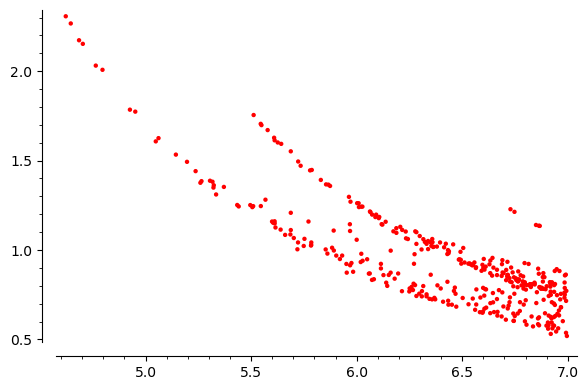

In [7]:
list_plot(Liste_discri_bounds, color='red')
# x : the root discriminant
# y : the bound



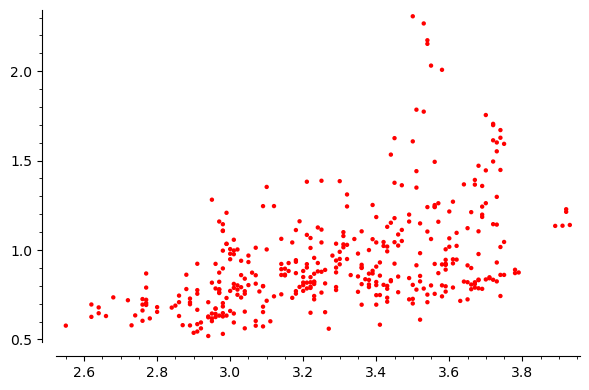

In [8]:
list_plot(Liste_lambda_bounds, color='red')
# x : lambda
# y : the bound

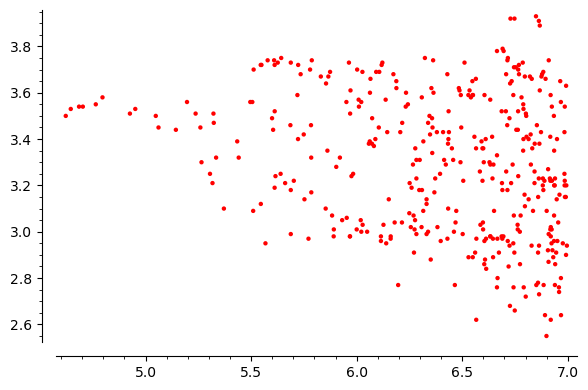

In [9]:
list_plot(Liste_lambda_discri, color='red')
# x : root discriminant
# y : the optimal lambda for "the" field associated to this root discriminant

In [5]:
Liste_field_bounds=[(x^6 - x^5 + x^4 - 2*x^3 + 4*x^2 - 3*x + 1, 2.30692631360329),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + 2*x^2 - 2*x + 1, 2.26682768778283),
 (x^6 - x^5 - x^4 + 2*x^3 - x + 1, 2.17290240324397),
 (x^6 - x^4 - 2*x^3 + 2*x + 1, 2.15277516503402),
 (x^6 - x^5 - x^2 + x + 1, 2.03112217539479),
 (x^6 - 3*x^5 + 5*x^4 - 5*x^3 + 5*x^2 - 3*x + 1, 2.00760657710700),
 (x^6 - x^5 + x^4 - 2*x^3 + x^2 + 1, 1.78467791963578),
 (x^6 - x^5 + x^3 - x^2 + 1, 1.77369923469441),
 (x^6 - x^5 - x^4 + 3*x^3 - 2*x + 1, 1.60745834786945),
 (x^6 - x^5 + x^4 - x^3 + x^2 - x + 1, 1.62552250667854),
 (x^6 + 2*x^4 - x^3 + 2*x^2 + 1, 1.53340194296238),
 (x^6 - x^3 + 1, 1.49308144741536),
 (x^6 - x^5 + x^4 - 2*x^3 + 2*x^2 - x + 1, 1.44098865920145),
 (x^6 - 3*x^5 + 4*x^4 - x^3 - 2*x^2 + x + 1, 1.37593581516445),
 (x^6 - x^5 + 2*x^4 - 3*x^3 + 2*x^2 - x + 1, 1.38499849703746),
 (x^6 + x^4 - x^3 - x + 1, 1.38726706327481),
 (x^6 - 2*x^5 + 2*x^4 - x^2 + 1, 1.38178734679118),
 (x^6 - x^5 + 4*x^4 - 4*x^3 + 5*x^2 - 3*x + 1, 1.34899647838071),
 (x^6 - x^5 - 2*x^3 + x^2 + x + 1, 1.36207484238639),
 (x^6 + x^4 - x^3 + x^2 - 2*x + 1, 1.31054987851850),
 (x^6 - x^5 + 3*x^3 - x^2 - 2*x + 1, 1.35271106668882),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + 3*x^2 - x + 1, 1.25172878192802),
 (x^6 - x^4 - 2*x^3 + x^2 + x + 1, 1.24363204563572),
 (x^6 - x^5 + 2*x^3 - x + 1, 1.25123890072054),
 (x^6 - x^5 + 2*x^4 + 2*x^2 - x + 1, 1.23975972223248),
 (x^6 - x^5 + x^4 - 2*x^3 + 3*x^2 - 2*x + 1, 1.24535965054860),
 (x^6 - 2*x^5 + 3*x^3 - 2*x - 1, 1.75479720441658),
 (x^6 - x^5 + x^4 - x^2 + 2*x - 1, 1.70548393594813),
 (x^6 - x^5 + 3*x^4 - x^3 + 3*x^2 - x + 1, 1.24562939414447),
 (x^6 - 2*x^5 + x^4 + x^3 - 2*x^2 + x + 1, 1.69833631173848),
 (x^6 - 3*x^5 + 7*x^4 - 9*x^3 + 7*x^2 - 3*x + 1, 1.28129309820200),
 (x^6 - x^5 + x^4 - 2*x^2 + x - 1, 1.67060720907410),
 (x^6 - x^4 - x^3 + x^2 + x + 1, 1.15912258929221),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + 4*x^2 - 4*x + 2, 1.15246390836973),
 (x^6 - 2*x^4 - x^3 + 2*x + 1, 1.62777428940021),
 (x^6 - x^4 - x^3 + 2*x^2 + 3*x + 1, 1.16053538164421),
 (x^6 - 2*x^5 + 2*x^4 - 3*x^3 + 2*x^2 - 2*x + 1, 1.61337068409031),
 (x^6 - x^5 + x^4 - x^3 + 2*x^2 - x + 1, 1.14870260892314),
 (x^6 - 3*x^4 - 2*x^3 + 3*x^2 + 3*x + 1, 1.12591596124280),
 (x^6 - x^5 + 2*x^3 - 2*x^2 + 1, 1.60129652298703),
 (x^6 - x^5 + 2*x^4 - x^3 + x^2 + 1, 1.11403918143109),
 (x^6 - 3*x^5 + 4*x^4 - 3*x^3 + x^2 - 1, 1.59354791987276),
 (x^6 - x^3 - x^2 + x + 1, 1.08448991907190),
 (x^6 - x^5 + x^4 + x^3 + x + 1, 1.08680343398689),
 (x^6 - x^4 + 1, 1.20806982166609),
 (x^6 + x^4 + 2*x^2 + 1, 1.11160959392052),
 (x^6 + x^4 - 1, 1.55179223401609),
 (x^6 - x^5 - 2*x^3 + 2*x + 1, 1.06707558079481),
 (x^6 - 3*x^5 + 5*x^3 - 3*x + 1, 1.00393526124520),
 (x^6 + x^4 + x^2 - x + 1, 1.04223776759592),
 (x^6 - x^5 - x^4 + 2*x^3 - x^2 + 1, 1.49478914974391),
 (x^6 - 2*x^4 - x^3 + 2*x^2 - 1, 1.47108400069829),
 (x^6 - 2*x^5 + x^4 - x^2 + x + 1, 1.02268407292906),
 (x^6 - x^5 + x^2 - x + 1, 1.06242199330828),
 (x^6 - 3*x^5 + 4*x^4 - 2*x^3 - 2*x^2 + 2*x + 1, 1.15926901789467),
 (x^6 - x^4 + x^2 - x - 1, 1.44515663320103),
 (x^6 - x^5 + x^4 + 1, 1.02483694394263),
 (x^6 - x^4 - x^3 + 2*x^2 + 2*x + 1, 1.02879173723279),
 (x^6 - x^5 + 3*x^4 - 3*x^3 + 3*x^2 - x + 1, 1.04213669386253),
 (x^6 - 2*x^5 + 2*x^4 - x^2 + 2*x - 1, 1.44758520107840),
 (x^6 - x^5 - 2*x^4 + 2*x^3 - 2*x + 1, 1.39186017861768),
 (x^6 - x^5 - 3*x^4 + 4*x^3 + 3*x^2 - 4*x + 1, 1.00315223907577),
 (x^6 - x^5 + 2*x^3 - 3*x^2 + 3*x - 1, 1.36687991920459),
 (x^6 - 2*x^5 + 3*x^4 - 3*x^3 + 4*x^2 - 2*x + 1, 0.979929451399871),
 (x^6 - 2*x^5 + 3*x^4 - 2*x^3 - 3*x^2 + 3*x - 1, 1.36553884240808),
 (x^6 - 2*x^4 + 2*x^2 - x - 1, 1.35818052389693),
 (x^6 - 2*x^5 + 3*x^4 - 2*x^3 + 2*x^2 + 1, 1.01269128160275),
 (x^6 - 3*x^5 + 3*x^4 - x^3 - x^2 + x + 1, 1.10866500958393),
 (x^6 - 2*x^5 - 2*x^4 + 5*x^3 + x^2 - 3*x + 1, 0.997219884675332),
 (x^6 - x^3 + x + 1, 0.968770654893789),
 (x^6 - x^3 + x^2 + 1, 0.949510815694567),
 (x^6 - x + 1, 0.968791098298522),
 (x^6 - 2*x^5 + 2*x^4 - x^2 + x + 1, 0.922097652392021),
 (x^6 - x^5 + x^4 - 2*x^3 + x^2 + 3*x + 1, 0.873368253652871),
 (x^6 - 2*x^4 - 3*x - 1, 1.29712763327539),
 (x^6 - x^5 + x^4 - x^3 + 3*x^2 - 3*x + 1, 1.14417914765090),
 (x^6 - x^5 + x^4 + x^2 - 2*x + 1, 1.10630979546526),
 (x^6 - x^5 - x^4 - x^3 + 2*x^2 + x + 1, 0.914460530078781),
 (x^6 - x^5 + x^4 + x - 1, 1.27008818513750),
 (x^6 + x^4 - x^3 + 3*x^2 - x + 1, 0.927271169366700),
 (x^6 - x^5 - x^3 + x + 1, 0.878254816560456),
 (x^6 - 2*x^5 + 2*x^4 - x^3 + 1, 1.05735431735266),
 (x^6 - x^5 + 2*x^3 - 2*x^2 + 2*x - 1, 1.26176082574831),
 (x^6 - x^5 - 3*x^4 + 3*x^3 + 3*x^2 - x - 1, 1.26148734501475),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + x^2 - 1, 1.23993043654015),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + x^2 + 1, 0.932663585194374),
 (x^6 - x^5 + x^4 - x^2 - 1, 1.24226118410270),
 (x^6 + x^2 - 2*x + 1, 0.978943674972184),
 (x^6 - 2*x^5 + 2*x^4 - x^3 - 1, 1.24255000711049),
 (x^6 - 3*x^5 + 2*x^4 - x^3 + x^2 + 2*x + 1, 0.939833496291263),
 (x^6 - 2*x^5 + 4*x^4 - 3*x^3 + 4*x^2 - 2*x + 1, 0.948326713707058),
 (x^6 - x^4 - 2*x^3 + x^2 + 2*x + 1, 0.867960782406160),
 (x^6 - 2*x^5 + 3*x^4 - x^3 + 1, 0.868758054258893),
 (x^6 - 2*x^5 + 3*x^4 - 2*x^3 - 1, 1.21536323467448),
 (x^6 - x - 1, 1.21166231752172),
 (x^6 - x^5 + 2*x^4 - x^3 - x^2 + 2*x + 1, 0.832711920031972),
 (x^6 - x^5 + x^4 + 2*x^3 - 4*x^2 + 3*x - 1, 1.19803082267400),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + 2*x^2 + 1, 0.836616046139588),
 (x^6 - 2*x^5 - x^4 + 4*x^3 - 3*x^2 + 3*x - 1, 1.18427924663824),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^2 + 3*x - 1, 1.19773916996532),
 (x^6 - 2*x^3 - 2*x^2 + x + 1, 1.17818416947119),
 (x^6 - 2*x^5 + x^4 + x^3 - 2*x^2 + x - 1, 1.18475335111038),
 (x^6 - x^5 + x^4 - x^3 + 1, 0.896963908855048),
 (x^6 - x^5 - 3*x^3 + 2*x^2 + x + 1, 0.922496485774829),
 (x^6 - x^4 - x^3 - x^2 + 1, 1.14446337751602),
 (x^6 - 2*x^4 - x^3 + x^2 + x - 1, 1.14203877943565),
 (x^6 - x^5 + 2*x^4 - x^3 + x^2 - 2*x + 1, 0.859655617870764),
 (x^6 - 3*x^5 + 2*x^4 + x^3 + x^2 - 2*x - 1, 1.15788955508727),
 (x^6 - 2*x^5 + 2*x^4 + 2*x + 1, 0.817304103177116),
 (x^6 - 2*x^3 + x^2 + 2*x + 2, 0.799336203781215),
 (x^6 - 2*x^5 + 3*x^4 - 2*x^3 + 3*x^2 - 2*x + 1, 0.860455973018622),
 (x^6 - 3*x^5 + 3*x^4 - 3*x^2 + 3, 0.873390000371391),
 (x^6 - x^5 - 2*x^3 + 2*x^2 + 1, 0.996437261043457),
 (x^6 - x^5 - 2*x^4 + 3*x^3 - x + 1, 1.10447233375502),
 (x^6 + 2*x^2 + 1, 0.839764461948655),
 (x^6 - x^5 + x^3 - 3*x^2 + 2*x - 1, 1.12204362448726),
 (x^6 - x^5 - 2*x^4 + 3*x^3 - 3*x + 1, 1.09587809169938),
 (x^6 - 2*x^5 + 3*x^4 + x^2 + 3*x + 1, 0.868654116649858),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + x^2 - 1, 1.12964945826428),
 (x^6 - 3*x^4 - x^3 + 3*x^2 + 1, 0.769682299640921),
 (x^6 - x^5 + 4*x^3 - 3*x^2 + x - 1, 1.11235262406187),
 (x^6 - 2*x^5 + 2*x^4 + x^3 - 4*x^2 + 4*x - 1, 1.10318171898286),
 (x^6 - x^3 + x^2 + x - 1, 1.06524813569162),
 (x^6 - x^4 - x^3 + x^2 - 1, 1.06141149462177),
 (x^6 - x^5 + 2*x^3 - 2*x + 1, 0.768086466500492),
 (x^6 - 2*x^5 + 2*x^3 - 2*x^2 + 2, 0.785042654666350),
 (x^6 - x^5 - x^4 + x^3 + 4*x^2 - 6*x + 3, 0.778693161137203),
 (x^6 - x^5 + x^3 + x^2 - x + 1, 0.793529492293961),
 (x^6 - x^5 + 2*x^4 - x^3 + 2*x^2 - 2*x + 1, 0.776132410825240),
 (x^6 + x^4 - x^3 + 2*x^2 - 2*x + 1, 0.811637574569175),
 (x^6 - x^5 + 4*x^4 + 3*x^2 + 3*x + 1, 0.922987688350233),
 (x^6 + 3*x^4 - 2*x^3 + 4*x^2 - 2*x + 1, 0.976482312264408),
 (x^6 - x^5 - x^4 + x^2 + 1, 0.803683274141749),
 (x^6 - x^5 + x^4 - x^3 - x^2 + x - 1, 1.10438710158158),
 (x^6 + x^2 + 1, 0.742945327179514),
 (x^6 - 2*x^4 + x^2 + 1, 1.03416795132196),
 (x^6 + x^2 - 1, 1.09969116879745),
 (x^6 + 2*x^4 - x^3 + 2*x^2 - 2*x + 1, 0.755839169251936),
 (x^6 - x^4 - x^3 + 2*x^2 + x - 1, 1.07819409892001),
 (x^6 - x^5 + 2*x^4 - x^3 + 4*x^2 + 2*x + 1, 1.00298242414451),
 (x^6 + x^4 - x^3 + 2*x^2 + 1, 0.740672844466162),
 (x^6 - x^5 + 2*x^4 - x^3 + 3*x^2 - x + 1, 0.770070520525861),
 (x^6 - x^5 + 2*x^4 - 3*x^3 + 4*x^2 - 2*x + 1, 0.798435912837655),
 (x^6 - x^3 + 2*x - 1, 1.06054997776836),
 (x^6 + 2*x^4 - x - 1, 1.04500591348425),
 (x^6 - 2*x^5 - 2*x^3 + 4*x^2 + x + 1, 0.752102768717728),
 (x^6 - 3*x^5 + 4*x^4 - 3*x^3 + x^2 + 1, 1.03459262391207),
 (x^6 - 2*x^5 + 4*x^4 - 6*x^3 + 6*x^2 - 5*x + 3, 0.740862392171600),
 (x^6 - x^5 + 3*x^4 + 5*x^2 - 2*x + 1, 1.00508787356981),
 (x^6 - 3*x^5 + 4*x^4 - 2*x^3 - 2*x^2 + 2*x - 1, 1.05041277590982),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + 3*x^2 - x + 1, 0.726824970286787),
 (x^6 - x^5 + 2*x^4 - 2*x^3 - 1, 1.04450898919746),
 (x^6 - 2*x^5 - x^4 + 2*x^3 + 2*x^2 - 2*x + 1, 0.861724137459487),
 (x^6 - 2*x^4 - x + 1, 1.02310467720437),
 (x^6 - x^5 + 3*x^4 - x^3 + 2*x^2 + x + 1, 0.723982451623232),
 (x^6 - x^5 - x^4 + x^3 - x^2 - x + 1, 1.06152029982461),
 (x^6 - x^5 - x^4 + 4*x^3 + 3*x^2 - 1, 1.04375505341001),
 (x^6 + x^4 - x^3 - 2*x^2 + 3*x - 1, 1.01673477704025),
 (x^6 - 2*x^5 + 2*x^4 - x^3 - 2*x^2 + 2*x - 1, 1.01827269133909),
 (x^6 + 3*x^4 - x^3 + 2*x^2 - 2*x + 1, 0.732450341144065),
 (x^6 - x^5 + x^4 - x^2 + x + 1, 0.724000954899543),
 (x^6 - 3*x^5 + 5*x^4 - 4*x^3 + 2*x^2 + x - 1, 1.01909523720887),
 (x^6 - x^4 + x^2 - x + 1, 0.802296436391668),
 (x^6 - 2*x^5 + 3*x^3 - 4*x^2 + 2*x - 1, 1.04225891914719),
 (x^6 - x^5 + 3*x^2 - 3*x + 1, 0.784907094560047),
 (x^6 + x^4 - 2*x^3 + x^2 + 1, 0.710783770474567),
 (x^6 - 2*x^5 + x^4 + 3*x^3 - 4*x^2 + 3*x - 1, 1.01511086632598),
 (x^6 - 3*x^5 + 5*x^4 - 5*x^3 + 3*x^2 - x - 1, 1.03523036673786),
 (x^6 - x^3 + 2*x^2 + 2*x - 1, 0.977442336473839),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + 4*x^2 + 3, 0.822319512469451),
 (x^6 + 2*x^4 - x^3 - 2*x - 1, 0.999639976237275),
 (x^6 - x^5 + x^4 - x^3 + 3*x^2 - 2*x + 1, 0.716229371919315),
 (x^6 - x^5 + 3*x^3 - x^2 - x + 2, 0.694341631656796),
 (x^6 - x^5 + 2*x^4 - x^3 + x^2 - 1, 0.982341499992408),
 (x^6 - 2*x^5 - x^4 + 3*x^3 - x - 1, 0.992466537204816),
 (x^6 - x^5 + x^4 - x^3 + 2*x^2 + x + 1, 0.694162196290172),
 (x^6 - 2*x^5 - 2*x^3 + 5*x^2 - 2*x - 1, 1.03149760656209),
 (x^6 - x^5 - x^3 + 2*x^2 + 2*x + 1, 0.771195261696847),
 (x^6 - x^5 - 4*x^4 + 3*x^3 + 6*x^2 - 5*x + 1, 0.789874162004957),
 (x^6 - x^5 - x^3 + 2*x + 1, 0.755242821670607),
 (x^6 - x^5 + 3*x^4 - 4*x^3 + 4*x^2 - 3*x + 3, 0.683157773102892),
 (x^6 - x^5 - x^4 + 4*x^3 - 2*x^2 - x + 1, 0.946373953984930),
 (x^6 - x^5 + 2*x + 1, 0.947935217784156),
 (x^6 - x^5 + x^4 - 2*x^3 - x + 1, 0.989755316718887),
 (x^6 - x^5 + 3*x^3 - x^2 + 1, 0.945037052928149),
 (x^6 - x^5 + x^3 - x - 1, 0.923649397507386),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + 4*x^2 - 2*x + 1, 0.731716966235100),
 (x^6 - 2*x^5 + 2*x^3 - 2*x^2 + x + 1, 1.01152158824205),
 (x^6 - 2*x^5 + x^4 + 2*x^3 - 3*x^2 + 3*x - 1, 0.930148826633451),
 (x^6 - x^5 + x^3 - x^2 + 2*x - 1, 0.923488020540011),
 (x^6 - x^5 + 2*x^4 + 2*x + 1, 0.696612168651231),
 (x^6 - x^5 + 2*x^4 + x^3 - x^2 + 2*x - 1, 0.925187606964684),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + 2*x^2 - x - 1, 0.919218795723019),
 (x^6 - x^5 + 2*x^4 - 4*x^2 - 2*x - 1, 0.913977573607256),
 (x^6 + x^4 - x^3 - x - 1, 0.919514219544601),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + 4*x^2 - 3*x + 1, 0.728393158459680),
 (x^6 - 3*x^5 + 2*x^4 + 2*x - 1, 0.916860691180282),
 (x^6 - 2*x^5 + x^4 + x^2 - x - 1, 0.930458106129861),
 (x^6 - x^5 - 2*x^4 + 4*x^3 - 4*x + 3, 0.665642583383832),
 (x^6 - 3*x^4 - x^3 + 2*x^2 + 3*x + 1, 0.899238047464889),
 (x^6 + x^4 - x^3 - x^2 - 1, 0.903710969681673),
 (x^6 - 2*x^5 + x^4 + x^3 + x^2 - 2*x + 1, 0.695295156075057),
 (x^6 - 2*x^5 + x^4 + 2*x^2 - 2*x + 1, 0.779608980728674),
 (x^6 - 2*x^5 + 3*x^3 - x^2 - 2*x + 2, 0.652318193329641),
 (x^6 - x^5 + x^4 - x^3 + 3*x^2 + 1, 0.734306470832372),
 (x^6 - x^5 + 2*x^4 - x^3 + 2*x^2 - 3*x + 1, 0.883745992812287),
 (x^6 - x^5 + 2*x^3 + x^2 - 3*x + 1, 0.917259778285630),
 (x^6 + 2*x^4 + 3*x^2 - x + 1, 0.649096418539937),
 (x^6 - 2*x^4 - 2*x^3 + 2*x^2 + 2*x + 1, 0.655358112099207),
 (x^6 - x^5 - x^4 + x^3 + x^2 - x + 1, 0.788296517364424),
 (x^6 - x^5 + x^4 - 3*x^3 + 2*x^2 - 2*x + 1, 0.899343429077315),
 (x^6 - x^5 - x^4 + x^3 - x^2 + x + 1, 0.950032042553270),
 (x^6 - x^5 - 4*x^4 + 4*x^3 + 4*x^2 - 6*x + 3, 0.744954785823568),
 (x^6 - x^5 + x^4 + 2*x^2 - 2*x + 1, 0.671774215411681),
 (x^6 - 2*x^5 - x^4 + x^3 + 4*x^2 + x - 5, 0.890274219132466),
 (x^6 - x^5 + x^3 + 2*x^2 - 3*x + 1, 0.781668421567367),
 (x^6 - 3*x^5 + 4*x^4 - 2*x^3 + 2*x - 1, 0.907154226123501),
 (x^6 - 2*x^5 + 2*x^4 - 4*x^3 + 3*x^2 + 2*x + 1, 0.779751867314959),
 (x^6 + 2*x^2 - x + 1, 0.677972576028575),
 (x^6 - 2*x^4 - 2*x^3 + 2*x^2 + x - 1, 0.920021353441215),
 (x^6 - x^5 - 2*x^4 + 3*x^3 + 3*x^2 - 6*x + 3, 0.646868416553964),
 (x^6 - x^5 - x^3 + x^2 - 1, 0.870634783307349),
 (x^6 - 3*x^4 - 2*x^3 + 6*x^2 - 2*x - 1, 0.941095443587673),
 (x^6 - 2*x^5 + 2*x^4 - 4*x^3 + 4*x^2 - 2*x + 2, 0.702915713830058),
 (x^6 - 2*x^4 - x^3 + 3*x^2 + x - 1, 0.856693657398718),
 (x^6 + x^4 - 2*x^3 - 2*x + 1, 0.955902678948576),
 (x^6 - x^5 + x^4 + x^3 - 2*x + 1, 0.759333748776216),
 (x^6 - 2*x^4 - 2*x^3 + 2*x^2 + x + 1, 0.707433913146229),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^2 + x - 1, 0.901545610043115),
 (x^6 + 2*x^4 - 2*x^3 + 2*x^2 + 1, 0.652969713073433),
 (x^6 - 2*x^5 - 2*x^4 + 4*x^3 + 3*x^2 - 4*x + 1, 0.725678814605455),
 (x^6 - x^4 - 2*x^3 - x^2 + 1, 0.889598075184499),
 (x^6 - 2*x^5 + 2*x^4 + x^3 - 3*x^2 + x + 1, 0.859863523877677),
 (x^6 - x^4 - x^3 + x^2 + 1, 0.633127969653271),
 (x^6 - 3*x^5 + 5*x^4 - x^3 - 2*x^2 + 2*x + 1, 0.653995992525640),
 (x^6 - 2*x^5 + 4*x^3 - 3*x^2 - 4*x + 5, 0.775640188743974),
 (x^6 + x^4 - x + 1, 0.628389315855427),
 (x^6 - x^5 - 4*x^4 + 4*x^3 + 3*x^2 - 5*x + 1, 0.855055325851576),
 (x^6 - x^5 + 2*x^4 - 4*x^3 + 2*x^2 - 2*x + 1, 0.920809981758137),
 (x^6 - x^5 + 2*x^4 + x^3 + x^2 + 2*x + 1, 0.762967434396886),
 (x^6 - x^4 - x^2 - x + 1, 0.943205195613882),
 (x^6 - 2*x^5 + 3*x^4 - x^3 + 2*x - 1, 0.874286923093482),
 (x^6 - x^4 - 3*x^3 + x^2 + 2*x + 1, 0.684199115444051),
 (x^6 - 2*x^5 + 3*x^4 - 3*x^3 - 1, 0.871010301922958),
 (x^6 - x^5 + x^4 + x^3 + 2, 0.610340650858351),
 (x^6 - 2*x^5 + 4*x^4 - 6*x^3 + 4*x^2 - 3*x + 1, 0.831292575555850),
 (x^6 - x^3 - 1, 0.888716148635691),
 (x^6 - 2*x^5 - x^4 + 4*x^3 - x^2 - 5*x - 1, 0.851400680496900),
 (x^6 - x^5 - x - 1, 0.860883110349705),
 (x^6 - x^5 + x^2 + x - 1, 0.933946607602625),
 (x^6 - x^5 - x^4 + x^3 - 2*x^2 + 3, 0.673039794225238),
 (x^6 - x^5 + 2*x^4 + x^3 - x^2 + 3*x - 1, 0.860722163228556),
 (x^6 - x^5 + x^4 + 2*x^2 - x + 1, 0.689001678053510),
 (x^6 - x^5 + x^4 - 2*x^3 + x^2 - 2*x + 1, 0.843013124482391),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 + 2, 0.708072692301885),
 (x^6 - x^5 + x^4 + x^3 - x^2 + x + 5, 0.735081510114791),
 (x^6 - x^5 - x^4 + 2*x^2 - x - 1, 0.823403106512461),
 (x^6 - x^5 - 2*x^4 + 3*x^3 - x^2 - 2*x + 1, 1.22803017180717),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + x^2 - x - 1, 0.902049787738327),
 (x^6 - x^4 - 2*x^3 + x^2 + 3*x + 1, 0.819898742155610),
 (x^6 - x^3 - 2*x^2 + 1, 0.874791747226643),
 (x^6 + 2*x^4 - x^3 + 3*x^2 - 2*x + 1, 0.644716419092806),
 (x^6 - x^5 + x^3 + x - 1, 0.797080985964516),
 (x^6 - 2*x^4 - 2*x^3 + 4*x^2 + 2*x + 1, 0.604134963513151),
 (x^6 + 2*x^4 - 2*x^3 + 3*x^2 - 3*x + 1, 0.603365317959904),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + 2*x^2 - 1, 0.847519347392224),
 (x^6 - 2*x^5 + 4*x^4 - x^3 + x^2 + 3*x + 1, 0.755358582759021),
 (x^6 - 2*x^4 - 2*x^3 + 3*x + 1, 1.21337561305680),
 (x^6 - 2*x^5 + 2*x^4 - 3*x^3 + 4*x^2 - 2*x + 1, 0.630783093541653),
 (x^6 + x^4 - x^3 - 2*x^2 - 2*x - 1, 0.841883697800363),
 (x^6 - x^5 - x^4 + 2*x^3 - x^2 - 2*x + 1, 0.831431824841397),
 (x^6 - x^5 - x^4 - 3*x^3 + 6*x^2 - 2*x + 1, 0.791998925135988),
 (x^6 - x^5 + x^4 + x + 1, 0.644905814622220),
 (x^6 - 2*x^5 + 2*x^3 - 2*x^2 + x - 1, 0.825442117169409),
 (x^6 - 2*x^5 - x^4 + 2*x^3 + 2*x^2 - 2*x - 1, 0.824485756622790),
 (x^6 - x^4 - 2*x^3 + x^2 + 2*x - 2, 0.835365352797939),
 (x^6 - 2*x^5 + 2*x^4 - 4*x^3 + 4*x^2 - 3*x + 1, 0.880372247143619),
 (x^6 - x^5 + 2*x^4 - x^3 - x^2 + x - 2, 0.833531548328015),
 (x^6 - x^5 + 2*x^4 - x^2 + 2*x - 2, 0.834504017869820),
 (x^6 + x^4 - 2*x^3 - x^2 + 2*x + 1, 0.659225587191868),
 (x^6 - x^5 - x^4 + 4*x^3 - 2*x^2 - 3*x + 3, 0.708181299740178),
 (x^6 - 2*x^5 + 2*x^4 - 2*x^3 - x^2 + 2*x + 1, 0.858804066513384),
 (x^6 - x^5 + x^3 - x^2 - 2*x - 1, 0.802305796351830),
 (x^6 - 2*x^5 - x^4 + 3*x^3 + x^2 - x - 2, 0.824458750486427),
 (x^6 - 2*x^5 + x^4 + 4*x^3 - 4*x^2 - 4*x - 1, 0.852207029044874),
 (x^6 - x^5 + 2*x^3 - x^2 - 3*x - 1, 0.801893180802803),
 (x^6 - x^5 + x^4 + 2*x^3 - 2*x^2 + x + 1, 0.821300686371198),
 (x^6 - x^5 - 2*x^4 + 5*x^3 - 2*x^2 - x + 1, 0.784350821794649),
 (x^6 - x^5 - x^3 + 2*x^2 - x + 1, 0.694770191048323),
 (x^6 - 3*x^5 + 5*x^4 - 5*x^3 + x^2 + x - 1, 0.927050590883623),
 (x^6 - 2*x^2 - 2*x + 1, 0.819522247827018),
 (x^6 + 2*x^4 + x^2 - x + 1, 0.601310262312734),
 (x^6 - 2*x^5 + 5*x^4 - 4*x^3 + 5*x^2 - 3*x + 5, 0.719125071378357),
 (x^6 - x^5 + x^4 - x^3 + 2*x - 1, 0.778493697422086),
 (x^6 - 2*x^5 + 2*x^3 - 3*x^2 + 2*x + 1, 0.805004271163249),
 (x^6 + x^4 + 3*x^2 - 2*x + 1, 0.582292201208850),
 (x^6 + x^4 - x^3 - 2*x^2 - x - 1, 0.803672554461997),
 (x^6 - 2*x^5 + 4*x^4 - 4*x^3 + 2*x^2 + x - 1, 0.922076183922486),
 (x^6 - 2*x^5 - x^4 + 2*x^3 + x^2 - 2*x - 1, 0.809260289754426),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + x^2 + x - 1, 0.805186281300894),
 (x^6 - x^5 - 2*x^4 + x^3 + 2*x^2 + x - 1, 0.792910653443595),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + 3*x^2 + 2, 0.628330058109751),
 (x^6 - 2*x^5 + 4*x^4 - 5*x^3 + 3*x^2 - 2*x - 1, 0.806930761862337),
 (x^6 - x^5 + x^2 - x - 1, 0.809081081038903),
 (x^6 - x^5 + 2*x^4 - 3*x^3 + 3*x^2 - x + 1, 0.572705340889222),
 (x^6 - x^5 + 2*x^4 - x^3 - 2*x^2 + 3*x - 1, 0.817484140289773),
 (x^6 - 2*x^5 + x^4 + x^3 - x^2 - 1, 0.813253608577073),
 (x^6 - 2*x^5 + 3*x^4 - 4*x^3 + x^2 - x - 1, 0.807259865209089),
 (x^6 - x^5 - x^4 - 2*x^3 + 2*x^2 + 3*x - 1, 1.13995317383951),
 (x^6 - x^5 - 2*x^4 + 4*x^3 + x^2 - 6*x + 4, 0.703393495474994),
 (x^6 - x^5 + x^4 + x^3 + 2*x + 1, 0.763938948661126),
 (x^6 - x^5 - 2*x^4 + 5*x^3 + 2*x^2 - 3*x + 1, 0.617480204104168),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + 3*x^2 - 3*x + 1, 0.585416529048551),
 (x^6 - x^4 - x^3 + x - 1, 0.895643303325871),
 (x^6 - 3*x^5 + 5*x^4 - 4*x^3 + x^2 - 1, 0.867209773924046),
 (x^6 - x^5 - x^4 + 2*x^3 - 2*x^2 - x + 1, 1.13584795310237),
 (x^6 - x^5 + 3*x^4 - 2*x^3 + 2*x^2 + 1, 0.623622523210310),
 (x^6 - x^5 + 2*x^3 + x^2 - 3*x + 3, 0.578761121109449),
 (x^6 - x^5 + x^4 + 2*x^3 - 3*x^2 + 2*x - 1, 0.792790440415067),
 (x^6 - x^5 + x^4 - x^3 - x^2 + 2*x + 1, 0.790135501911735),
 (x^6 - 2*x^5 - x^4 + x^3 + 2*x^2 + x - 1, 1.13471602313221),
 (x^6 - x^4 - 2*x - 1, 0.783138681072301),
 (x^6 - x^5 + x^3 - 3*x^2 + x - 1, 0.789649684231130),
 (x^6 - x^5 + 3*x^4 + 2*x - 1, 0.785897472504208),
 (x^6 - x^5 - x^4 + 2*x^2 + 3*x + 1, 0.848768832523104),
 (x^6 - 2*x^5 + x^3 + 2*x^2 - 2*x - 1, 0.823571378347672),
 (x^6 - 2*x^5 + x^4 + 3*x^3 - 3*x^2 + x + 1, 0.782747536085676),
 (x^6 - 2*x^5 + x^4 - 2*x^2 + 2*x + 1, 0.870673825708855),
 (x^6 - 2*x^5 + 3*x^4 + 2*x + 1, 0.721662538243639),
 (x^6 - 2*x^5 + x^4 + x^3 - 4*x^2 + 3*x - 1, 0.848174177340452),
 (x^6 - x^3 + 7, 0.646346282852398),
 (x^6 - x^5 + x^4 - x^3 - x - 1, 0.780701591399768),
 (x^6 - x^4 - 2*x^3 + 3*x^2 + x + 1, 0.577069017978517),
 (x^6 - 2*x^5 + 2*x^4 - x^3 + 3*x^2 - 3*x + 1, 0.797403052697921),
 (x^6 - x^5 - 3*x^4 + 2*x^3 + x^2 + 3, 0.594763041924071),
 (x^6 - 2*x^5 - 2*x^4 + 4*x^3 + x^2 - 2*x + 2, 0.559909825231870),
 (x^6 - x^5 + 2*x^4 - 2*x^3 + x^2 + 1, 0.579718624472981),
 (x^6 - 2*x^5 + 4*x^4 - 2*x^3 + 2*x^2 + 2, 0.633272017135005),
 (x^6 - x^5 + x^4 - 2*x^2 + 3*x - 1, 0.742742474021303),
 (x^6 - x^5 + x^3 - x^2 - 1, 0.820300821320498),
 (x^6 - x^5 - x^3 - x + 1, 0.748248824617531),
 (x^6 - 5*x^4 - 2*x^3 + 7*x^2 + 5*x + 1, 0.810523033579176),
 (x^6 - x^5 - 2*x^3 - x - 1, 0.795139939792773),
 (x^6 - x^5 + x^4 + 2*x^3 - 2*x^2 + 2*x - 1, 0.767429369501654),
 (x^6 - x^5 - x^4 + x^3 + 2*x^2 - 2*x + 1, 0.626146580154866),
 (x^6 - x^5 + 2*x^4 + x^3 + 2*x^2 + 3*x + 1, 0.530865133804940),
 (x^6 - 3*x^5 + 4*x^4 - 3*x^3 + 4*x^2 - 3*x + 1, 0.749566723045125),
 (x^6 - 3*x^4 - 3*x^3 + 3*x^2 + 6*x + 3, 0.617571374532423),
 (x^6 - x^4 - 2*x^3 - x^2 + 2*x + 2, 0.594743165333389),
 (x^6 + 2*x^4 + 2*x^2 - 1, 0.708070331527507),
 (x^6 - x^5 - x^4 + 2*x^3 - x - 1, 0.819639892826059),
 (x^6 - 2*x^5 + 3*x^4 - 3*x^3 + 4*x^2 - x + 1, 0.561825381519780),
 (x^6 - 2*x^5 + 4*x^4 - 5*x^3 + 6*x^2 - 5*x + 2, 0.578268400071085),
 (x^6 - x^5 + x^4 - x^2 - 3*x - 1, 0.700987974026635),
 (x^6 - 2*x^3 + x^2 + x + 1, 0.625003805666594),
 (x^6 - 2*x^4 - 3*x^3 + x^2 + 4*x + 2, 0.576656272481097),
 (x^6 - 2*x^5 + 2*x^4 - x^3 + 2*x - 1, 0.766108788175481),
 (x^6 - 2*x^5 + 3*x^4 - 3*x^3 + x - 1, 0.803472927696214),
 (x^6 - 3*x^5 + 3*x^4 + x^3 - 3*x^2 + 3*x - 1, 0.882609159335612),
 (x^6 - x^5 + 4*x^4 - 4*x^3 + 6*x^2 - 4*x + 5, 0.692703405850802),
 (x^6 + x^4 - 3*x^3 - x + 1, 0.809993944086185),
 (x^6 - x^5 - x^4 - x^3 + 2*x^2 + 3*x + 1, 0.630920301512004),
 (x^6 + 3*x^4 - 2*x^3 + 3*x^2 - 2*x + 2, 0.544199278253130),
 (x^6 - 2*x^5 - 2*x^4 + 5*x^3 + 2*x^2 - 2*x - 1, 0.892929696775898),
 (x^6 - x^5 + 2*x^4 + 2*x - 1, 0.747501175420777),
 (x^6 - 2*x^5 + 3*x^4 - 3*x^3 + 4*x^2 - 4*x + 2, 0.642718365781245),
 (x^6 - 2*x^5 + 4*x^4 - 3*x^3 + 2*x^2 + x + 1, 0.562035194262591),
 (x^6 - 2*x^5 + 2*x^4 - x^3 - x^2 + x + 1, 0.661855703504213),
 (x^6 - x^5 + x^4 + x^3 + x^2 - x + 1, 0.634374560316308),
 (x^6 - 2*x^5 + 2*x^4 - 3*x^2 + 2*x - 1, 0.882603743496200),
 (x^6 - x^5 + 2*x^3 - x^2 + x + 1, 0.723875478521509),
 (x^6 - x^5 - x^4 + 2*x^3 - 4*x^2 + 2*x - 1, 0.754882402110440),
 (x^6 - x^5 + 3*x^4 - 3*x^3 + 5*x^2 - 2*x + 4, 0.680563067238386),
 (x^6 - x^5 - x^4 + 2*x^3 + 2*x^2 - 3*x + 1, 0.678947205914951),
 (x^6 - x^4 - 3*x^3 + x^2 + x + 2, 0.602096558179364),
 (x^6 - x^5 + x^3 - 2*x^2 - x + 1, 0.761937114548407),
 (x^6 - x^3 - 2*x^2 - 1, 0.733141801408439),
 (x^6 - x^5 + 4*x^4 - x^3 + 3*x^2 - 1, 0.818200131753060),
 (x^6 - 2*x^2 - 3*x - 1, 0.787849683022160),
 (x^6 - x^5 - 2*x^4 - 2*x^3 + 2*x^2 + 3*x + 1, 0.750531962276719),
 (x^6 - 2*x^5 + 6*x^3 - 7*x^2 + 2*x - 1, 0.858023860129031),
 (x^6 - 3*x^5 + 5*x^4 - 4*x^3 + x - 1, 0.862373258597201),
 (x^6 - 2*x^5 + x^4 - 2*x^3 + 3*x^2 - 2*x + 2, 0.536932703666891),
 (x^6 - x^5 - 2*x^4 + 2*x^3 - x^2 + x + 1, 0.715359963685051),
 (x^6 - x^5 + 2*x^4 - 3*x^3 + 2*x^2 - 3*x + 1, 0.771417508201734),
 (x^6 - x^5 - x^4 + 5*x^3 + 2*x^2 - 4*x + 1, 0.519148798541012)]

In [6]:
Liste_discri_bounds=[(4.621807230586968, 2.30692631360329),
 (4.64552582628722, 2.26682768778283),
 (4.684745601745479, 2.17290240324397),
 (4.7026693754415145, 2.15277516503402),
 (4.764038656085337, 2.03112217539479),
 (4.795831523312719, 2.00760657710700),
 (4.925722099070367, 1.78467791963578),
 (4.951141879158968, 1.77369923469441),
 (5.0482095388420625, 1.60745834786945),
 (5.061140184796386, 1.62552250667854),
 (5.143443253632608, 1.53340194296238),
 (5.196152422706632, 1.49308144741536),
 (5.236880671439292, 1.44098865920145),
 (5.259526380991987, 1.37593581516445),
 (5.26481368119397, 1.38499849703746),
 (5.305035062757632, 1.38726706327481),
 (5.316907603004571, 1.38178734679118),
 (5.3214088390366205, 1.34899647838071),
 (5.32297003373077, 1.36207484238639),
 (5.3339892066059775, 1.31054987851850),
 (5.370865221797644, 1.35271106668882),
 (5.434018410808422, 1.25172878192802),
 (5.441030895855758, 1.24363204563572),
 (5.4958646600950125, 1.25123890072054),
 (5.505528329597814, 1.23975972223248),
 (5.509573725385251, 1.24535965054860),
 (5.511738317711919, 1.75479720441658),
 (5.545298548827071, 1.70548393594813),
 (5.545870533773097, 1.24562939414447),
 (5.548852784107656, 1.69833631173848),
 (5.5677643628300215, 1.28129309820200),
 (5.5781198683813065, 1.67060720907410),
 (5.59900150547258, 1.15912258929221),
 (5.604078661310774, 1.15246390836973),
 (5.608802684175703, 1.62777428940021),
 (5.611142273525777, 1.16053538164421),
 (5.611202198898904, 1.61337068409031),
 (5.6115017777762075, 1.14870260892314),
 (5.615209928709746, 1.12591596124280),
 (5.625965841690932, 1.60129652298703),
 (5.63954535118465, 1.11403918143109),
 (5.642404941390967, 1.59354791987276),
 (5.6609612194990815, 1.08448991907190),
 (5.6859125257820455, 1.08680343398689),
 (5.687733959703131, 1.20806982166609),
 (5.687733959703131, 1.11160959392052),
 (5.687733959703131, 1.55179223401609),
 (5.70206321806223, 1.06707558079481),
 (5.71910575798162, 1.00393526124520),
 (5.722016738068573, 1.04223776759592),
 (5.722722962069444, 1.49478914974391),
 (5.73439385986008, 1.47108400069829),
 (5.749082854700137, 1.02268407292906),
 (5.752474616170947, 1.06242199330828),
 (5.771577549142032, 1.15926901789467),
 (5.779099990532804, 1.44515663320103),
 (5.783487038348729, 1.02483694394263),
 (5.784516870803282, 1.02879173723279),
 (5.784928547231771, 1.04213669386253),
 (5.787215827911008, 1.44758520107840),
 (5.830086168369163, 1.39186017861768),
 (5.852971512380733, 1.00315223907577),
 (5.8547656906246, 1.36687991920459),
 (5.861192432770098, 0.979929451399871),
 (5.865761483884521, 1.36553884240808),
 (5.873798193701521, 1.35818052389693),
 (5.8833655068657595, 1.01269128160275),
 (5.890883859184457, 1.10866500958393),
 (5.891635409232866, 0.997219884675332),
 (5.903153840633991, 0.968770654893789),
 (5.920395415277274, 0.949510815694567),
 (5.931070786715124, 0.968791098298522),
 (5.951155716237506, 0.922097652392021),
 (5.9527845166566316, 0.873368253652871),
 (5.963196213261342, 1.29712763327539),
 (5.967652705599546, 1.14417914765090),
 (5.968445187518787, 1.10630979546526),
 (5.968885228016165, 0.914460530078781),
 (5.970599837878764, 1.27008818513750),
 (5.975138249908744, 0.927271169366700),
 (5.9830772825868275, 0.878254816560456),
 (5.999892827861798, 1.05735431735266),
 (6.002162830486002, 1.26176082574831),
 (6.009074842039987, 1.26148734501475),
 (6.010520476161419, 1.23993043654015),
 (6.0190524986327425, 0.932663585194374),
 (6.021518249301834, 1.24226118410270),
 (6.021749812557613, 0.978943674972184),
 (6.027063519358255, 1.24255000711049),
 (6.028027135679239, 0.939833496291263),
 (6.0494458548965655, 0.948326713707058),
 (6.057585402400234, 0.867960782406160),
 (6.061807852330189, 0.868758054258893),
 (6.062805220164698, 1.21536323467448),
 (6.065183377776943, 1.21166231752172),
 (6.07243131635689, 0.832711920031972),
 (6.073117423490182, 1.19803082267400),
 (6.081440856496521, 0.836616046139588),
 (6.088353722229382, 1.18427924663824),
 (6.09217289660931, 1.19773916996532),
 (6.104660492385436, 1.17818416947119),
 (6.106860215165769, 1.18475335111038),
 (6.114723188493255, 0.896963908855048),
 (6.114742685200948, 0.922496485774829),
 (6.11803317263662, 1.14446337751602),
 (6.121605682277751, 1.14203877943565),
 (6.1267519315597365, 0.859655617870764),
 (6.137094928113859, 1.15788955508727),
 (6.139753075547641, 0.817304103177116),
 (6.144633651371694, 0.799336203781215),
 (6.151918368414652, 0.860455973018622),
 (6.160719920478346, 0.873390000371391),
 (6.161020360965441, 0.996437261043457),
 (6.173814792445766, 1.10447233375502),
 (6.179746605865644, 0.839764461948655),
 (6.18765454265801, 1.12204362448726),
 (6.188003611274618, 1.09587809169938),
 (6.196406606212536, 0.868654116649858),
 (6.206382992433788, 1.12964945826428),
 (6.214303166344225, 0.769682299640921),
 (6.215561410054191, 1.11235262406187),
 (6.232122972308053, 1.10318171898286),
 (6.233611266114746, 1.06524813569162),
 (6.242503925323633, 1.06141149462177),
 (6.249132093417714, 0.768086466500492),
 (6.25075745793257, 0.785042654666350),
 (6.256316635058824, 0.778693161137203),
 (6.259928168977115, 0.793529492293961),
 (6.266516632686616, 0.776132410825240),
 (6.2693247730636905, 0.811637574569175),
 (6.271319380605968, 0.922987688350233),
 (6.27401393708217, 0.976482312264408),
 (6.276394743781217, 0.803683274141749),
 (6.277455231724821, 1.10438710158158),
 (6.2827613047827855, 0.742945327179514),
 (6.2827613047827855, 1.03416795132196),
 (6.2827613047827855, 1.09969116879745),
 (6.296224127519462, 0.755839169251936),
 (6.298546471018299, 1.07819409892001),
 (6.307158895178334, 1.00298242414451),
 (6.308360621329956, 0.740672844466162),
 (6.309161136650305, 0.770070520525861),
 (6.315231836118938, 0.798435912837655),
 (6.31564657138213, 1.06054997776836),
 (6.323055643761327, 1.04500591348425),
 (6.330913285930754, 0.752102768717728),
 (6.330913285930754, 1.03459262391207),
 (6.330913285930754, 0.740862392171600),
 (6.338103410186691, 1.00508787356981),
 (6.338135999601272, 1.05041277590982),
 (6.344669527212984, 0.726824970286787),
 (6.34748707178713, 1.04450898919746),
 (6.350637251832455, 0.861724137459487),
 (6.353811827471928, 1.02310467720437),
 (6.356930328030721, 0.723982451623232),
 (6.3578611797342, 1.06152029982461),
 (6.359079885915125, 1.04375505341001),
 (6.362025610924939, 1.01673477704025),
 (6.363687574069198, 1.01827269133909),
 (6.367928518008335, 0.732450341144065),
 (6.371885667587409, 0.724000954899543),
 (6.3798106096232745, 1.01909523720887),
 (6.38242561664828, 0.802296436391668),
 (6.394860016878899, 1.04225891914719),
 (6.39794203674835, 0.784907094560047),
 (6.409164302405515, 0.710783770474567),
 (6.414040428191513, 1.01511086632598),
 (6.4220602344839675, 1.03523036673786),
 (6.42930224838387, 0.977442336473839),
 (6.429757313914919, 0.822319512469451),
 (6.4324540624674915, 0.999639976237275),
 (6.4332256855576135, 0.716229371919315),
 (6.434420032030963, 0.694341631656796),
 (6.435235783416772, 0.982341499992408),
 (6.436805404927777, 0.992466537204816),
 (6.450876432394831, 0.694162196290172),
 (6.456978988762954, 1.03149760656209),
 (6.460582303802486, 0.771195261696847),
 (6.464898963425158, 0.789874162004957),
 (6.468141747969118, 0.755242821670607),
 (6.471655403489675, 0.683157773102892),
 (6.4837259383246275, 0.946373953984930),
 (6.486980021012138, 0.947935217784156),
 (6.49161459887966, 0.989755316718887),
 (6.493117280989744, 0.945037052928149),
 (6.495238302997562, 0.923649397507386),
 (6.502011005426689, 0.731716966235100),
 (6.504733138041515, 1.01152158824205),
 (6.510673365476573, 0.930148826633451),
 (6.529007736485903, 0.923488020540011),
 (6.529653782171692, 0.696612168651231),
 (6.534502955593589, 0.925187606964684),
 (6.540755043499068, 0.919218795723019),
 (6.547974660107998, 0.913977573607256),
 (6.549081845121054, 0.919514219544601),
 (6.549718052962243, 0.728393158459680),
 (6.55085139683376, 0.916860691180282),
 (6.557575977501084, 0.930458106129861),
 (6.5609527987944425, 0.665642583383832),
 (6.564485031706258, 0.899238047464889),
 (6.565414427346138, 0.903710969681673),
 (6.566152008492678, 0.695295156075057),
 (6.566820936771799, 0.779608980728674),
 (6.58342097651413, 0.652318193329641),
 (6.586006006036635, 0.734306470832372),
 (6.591268076606057, 0.883745992812287),
 (6.5956148917565205, 0.917259778285630),
 (6.595855220238613, 0.649096418539937),
 (6.59789624667252, 0.655358112099207),
 (6.598735752549555, 0.788296517364424),
 (6.599614662504979, 0.899343429077315),
 (6.601849250718657, 0.950032042553270),
 (6.604212731240361, 0.744954785823568),
 (6.604902388705974, 0.671774215411681),
 (6.605300104288982, 0.890274219132466),
 (6.607882341442277, 0.781668421567367),
 (6.610908387253838, 0.907154226123501),
 (6.612623152918087, 0.779751867314959),
 (6.613413833928783, 0.677972576028575),
 (6.62894679916659, 0.920021353441215),
 (6.632561553611812, 0.646868416553964),
 (6.632587523378523, 0.870634783307349),
 (6.633054892262308, 0.941095443587673),
 (6.6332495807108, 0.702915713830058),
 (6.641439508946083, 0.856693657398718),
 (6.64317965991124, 0.955902678948576),
 (6.645226252462388, 0.759333748776216),
 (6.645997733203736, 0.707433913146229),
 (6.647667740344748, 0.901545610043115),
 (6.650578810106002, 0.652969713073433),
 (6.664443703291906, 0.725678814605455),
 (6.664443703291906, 0.889598075184499),
 (6.6645577947560275, 0.859863523877677),
 (6.6663566132578715, 0.633127969653271),
 (6.667166555587835, 0.653995992525640),
 (6.67362844907442, 0.775640188743974),
 (6.686409281820092, 0.628389315855427),
 (6.686533981034542, 0.855055325851576),
 (6.688129104938426, 0.920809981758137),
 (6.689697449377527, 0.762967434396886),
 (6.69002084730078, 0.943205195613882),
 (6.691065137490304, 0.874286923093482),
 (6.694912028685515, 0.684199115444051),
 (6.696026800800036, 0.871010301922958),
 (6.7065711310660125, 0.610340650858351),
 (6.707811259537645, 0.831292575555850),
 (6.708203932499369, 0.888716148635691),
 (6.713004874329409, 0.851400680496900),
 (6.713921468207409, 0.860883110349705),
 (6.71398255222457, 0.933946607602625),
 (6.71547214188382, 0.673039794225238),
 (6.7160821524665995, 0.860722163228556),
 (6.719517435146649, 0.689001678053510),
 (6.723623365291746, 0.843013124482391),
 (6.723950813597926, 0.708072692301885),
 (6.725877504819486, 0.735081510114791),
 (6.726628045978122, 0.823403106512461),
 (6.728345451343875, 1.22803017180717),
 (6.731460210056998, 0.902049787738327),
 (6.734062384218769, 0.819898742155610),
 (6.73858013716227, 0.874791747226643),
 (6.741767084521135, 0.644716419092806),
 (6.741874781914704, 0.797080985964516),
 (6.742867585976025, 0.604134963513151),
 (6.74434945105711, 0.603365317959904),
 (6.7450420230505586, 0.847519347392224),
 (6.74673613104636, 0.755358582759021),
 (6.747355976924159, 1.21337561305680),
 (6.748690063397603, 0.630783093541653),
 (6.753610006723565, 0.841883697800363),
 (6.75602775080137, 0.831431824841397),
 (6.762100407882592, 0.791998925135988),
 (6.762807503898939, 0.644905814622220),
 (6.763396468331329, 0.825442117169409),
 (6.764467725984156, 0.824485756622790),
 (6.764985392639854, 0.835365352797939),
 (6.765185347177232, 0.880372247143619),
 (6.768333673607606, 0.833531548328015),
 (6.768744295518181, 0.834504017869820),
 (6.772726726850797, 0.659225587191868),
 (6.7735101207809505, 0.708181299740178),
 (6.776464231812388, 0.858804066513384),
 (6.780714778563739, 0.802305796351830),
 (6.786515906195316, 0.824458750486427),
 (6.788459532273914, 0.852207029044874),
 (6.788968117706077, 0.801893180802803),
 (6.789799937726492, 0.821300686371198),
 (6.790019360840177, 0.784350821794649),
 (6.791127483220962, 0.694770191048323),
 (6.795102353070949, 0.927050590883623),
 (6.796378755919721, 0.819522247827018),
 (6.796826937382553, 0.601310262312734),
 (6.80063625546765, 0.719125071378357),
 (6.801438064687226, 0.778493697422086),
 (6.803074578975453, 0.805004271163249),
 (6.80435495127094, 0.582292201208850),
 (6.814157809432606, 0.803672554461997),
 (6.814339310371814, 0.922076183922486),
 (6.820529883758517, 0.809260289754426),
 (6.823924449885552, 0.805186281300894),
 (6.825039092247243, 0.792910653443595),
 (6.828366342139099, 0.628330058109751),
 (6.829185669140272, 0.806930761862337),
 (6.831562302286011, 0.809081081038903),
 (6.835164205021656, 0.572705340889222),
 (6.842217421752536, 0.817484140289773),
 (6.842406344103017, 0.813253608577073),
 (6.843161772807945, 0.807259865209089),
 (6.849256585035086, 1.13995317383951),
 (6.850803670688354, 0.703393495474994),
 (6.85347380631779, 0.763938948661126),
 (6.858831465731008, 0.617480204104168),
 (6.859007132764236, 0.585416529048551),
 (6.859501075727159, 0.895643303325871),
 (6.862570509615835, 0.867209773924046),
 (6.8628989707133, 1.13584795310237),
 (6.8636431916686265, 0.623622523210310),
 (6.863862003418638, 0.578761121109449),
 (6.865458273531722, 0.792790440415067),
 (6.867150915481418, 0.790135501911735),
 (6.867183655722214, 1.13471602313221),
 (6.872988156342631, 0.783138681072301),
 (6.875083942647544, 0.789649684231130),
 (6.878118794277138, 0.785897472504208),
 (6.881449416167539, 0.848768832523104),
 (6.881881373627137, 0.823571378347672),
 (6.883855852143325, 0.782747536085676),
 (6.884071470583155, 0.870673825708855),
 (6.885450629608775, 0.721662538243639),
 (6.889203991632472, 0.848174177340452),
 (6.891929250299707, 0.646346282852398),
 (6.894649131384497, 0.780701591399768),
 (6.8988575735511795, 0.577069017978517),
 (6.899923666501133, 0.797403052697921),
 (6.9057512809257915, 0.594763041924071),
 (6.906652999966736, 0.559909825231870),
 (6.908634712406719, 0.579718624472981),
 (6.909365215205625, 0.633272017135005),
 (6.909672122898006, 0.742742474021303),
 (6.914910780457436, 0.820300821320498),
 (6.916964910438107, 0.748248824617531),
 (6.917164893446425, 0.810523033579176),
 (6.9173964166092246, 0.795139939792773),
 (6.9185744796768835, 0.767429369501654),
 (6.919226190693015, 0.626146580154866),
 (6.919320768399538, 0.530865133804940),
 (6.919320768399538, 0.749566723045125),
 (6.922836571416003, 0.617571374532423),
 (6.9235177090610565, 0.594743165333389),
 (6.9243555726270385, 0.708070331527507),
 (6.924742913148049, 0.819639892826059),
 (6.927231868906878, 0.561825381519780),
 (6.931029879779582, 0.578268400071085),
 (6.934037939895832, 0.700987974026635),
 (6.93444337262558, 0.625003805666594),
 (6.934911032394481, 0.576656272481097),
 (6.935253882701561, 0.766108788175481),
 (6.935253882701561, 0.803472927696214),
 (6.938035108815338, 0.882609159335612),
 (6.938884968327756, 0.692703405850802),
 (6.939320060751249, 0.809993944086185),
 (6.940169134002444, 0.630920301512004),
 (6.944809143654867, 0.544199278253130),
 (6.9473344754232595, 0.892929696775898),
 (6.948734313637158, 0.747501175420777),
 (6.950533504083674, 0.642718365781245),
 (6.95447330074121, 0.562035194262591),
 (6.957942151741339, 0.661855703504213),
 (6.9585960687222785, 0.634374560316308),
 (6.960566178933555, 0.882603743496200),
 (6.9640402473947995, 0.723875478521509),
 (6.967170684853975, 0.754882402110440),
 (6.9673940186130485, 0.680563067238386),
 (6.967840578779475, 0.678947205914951),
 (6.9762981565004365, 0.602096558179364),
 (6.984032902143108, 0.761937114548407),
 (6.984083053140437, 0.733141801408439),
 (6.984805027927871, 0.818200131753060),
 (6.9855266297783665, 0.787849683022160),
 (6.9855967656382205, 0.750531962276719),
 (6.986368027818105, 0.858023860129031),
 (6.990567435982141, 0.862373258597201),
 (6.991555461906034, 0.536932703666891),
 (6.991844751483536, 0.715359963685051),
 (6.99299134545666, 0.771417508201734),
 (6.995610028603815, 0.519148798541012)]

In [7]:
Liste_lambda_bounds=[(3.50000000000000, 2.30692631360329),
 (3.53000000000000, 2.26682768778283),
 (3.54000000000000, 2.17290240324397),
 (3.54000000000000, 2.15277516503402),
 (3.55000000000000, 2.03112217539479),
 (3.58000000000000, 2.00760657710700),
 (3.51000000000000, 1.78467791963578),
 (3.53000000000000, 1.77369923469441),
 (3.50000000000000, 1.60745834786945),
 (3.45000000000000, 1.62552250667854),
 (3.44000000000000, 1.53340194296238),
 (3.56000000000000, 1.49308144741536),
 (3.51000000000000, 1.44098865920145),
 (3.45000000000000, 1.37593581516445),
 (3.30000000000000, 1.38499849703746),
 (3.25000000000000, 1.38726706327481),
 (3.21000000000000, 1.38178734679118),
 (3.51000000000000, 1.34899647838071),
 (3.47000000000000, 1.36207484238639),
 (3.32000000000000, 1.31054987851850),
 (3.10000000000000, 1.35271106668882),
 (3.39000000000000, 1.25172878192802),
 (3.32000000000000, 1.24363204563572),
 (3.56000000000000, 1.25123890072054),
 (3.56000000000000, 1.23975972223248),
 (3.09000000000000, 1.24535965054860),
 (3.70000000000000, 1.75479720441658),
 (3.72000000000000, 1.70548393594813),
 (3.12000000000000, 1.24562939414447),
 (3.72000000000000, 1.69833631173848),
 (2.95000000000000, 1.28129309820200),
 (3.74000000000000, 1.67060720907410),
 (3.49000000000000, 1.15912258929221),
 (3.44000000000000, 1.15246390836973),
 (3.74000000000000, 1.62777428940021),
 (3.19000000000000, 1.16053538164421),
 (3.72000000000000, 1.61337068409031),
 (3.52000000000000, 1.14870260892314),
 (3.24000000000000, 1.12591596124280),
 (3.73000000000000, 1.60129652298703),
 (3.25000000000000, 1.11403918143109),
 (3.75000000000000, 1.59354791987276),
 (3.21000000000000, 1.08448991907190),
 (3.46000000000000, 1.08680343398689),
 (2.99000000000000, 1.20806982166609),
 (3.18000000000000, 1.11160959392052),
 (3.73000000000000, 1.55179223401609),
 (3.22000000000000, 1.06707558079481),
 (3.59000000000000, 1.00393526124520),
 (3.40000000000000, 1.04223776759592),
 (3.72000000000000, 1.49478914974391),
 (3.68000000000000, 1.47108400069829),
 (3.42000000000000, 1.02268407292906),
 (3.14000000000000, 1.06242199330828),
 (2.97000000000000, 1.15926901789467),
 (3.70000000000000, 1.44515663320103),
 (3.46000000000000, 1.02483694394263),
 (3.32000000000000, 1.02879173723279),
 (3.17000000000000, 1.04213669386253),
 (3.74000000000000, 1.44758520107840),
 (3.67000000000000, 1.39186017861768),
 (3.10000000000000, 1.00315223907577),
 (3.64000000000000, 1.36687991920459),
 (3.35000000000000, 0.979929451399871),
 (3.67000000000000, 1.36553884240808),
 (3.69000000000000, 1.35818052389693),
 (3.07000000000000, 1.01269128160275),
 (2.98000000000000, 1.10866500958393),
 (3.01000000000000, 0.997219884675332),
 (3.28000000000000, 0.968770654893789),
 (3.32000000000000, 0.949510815694567),
 (3.05000000000000, 0.968791098298522),
 (3.56000000000000, 0.922097652392021),
 (3.06000000000000, 0.873368253652871),
 (3.73000000000000, 1.29712763327539),
 (2.98000000000000, 1.14417914765090),
 (2.98000000000000, 1.10630979546526),
 (3.51000000000000, 0.914460530078781),
 (3.61000000000000, 1.27008818513750),
 (3.24000000000000, 0.927271169366700),
 (3.25000000000000, 0.878254816560456),
 (3.01000000000000, 1.05735431735266),
 (3.70000000000000, 1.26176082574831),
 (3.57000000000000, 1.26148734501475),
 (3.54000000000000, 1.23993043654015),
 (3.05000000000000, 0.932663585194374),
 (3.56000000000000, 1.24226118410270),
 (3.00000000000000, 0.978943674972184),
 (3.69000000000000, 1.24255000711049),
 (3.03000000000000, 0.939833496291263),
 (3.00000000000000, 0.948326713707058),
 (3.38000000000000, 0.867960782406160),
 (3.39000000000000, 0.868758054258893),
 (3.60000000000000, 1.21536323467448),
 (3.66000000000000, 1.21166231752172),
 (3.38000000000000, 0.832711920031972),
 (3.49000000000000, 1.19803082267400),
 (3.37000000000000, 0.836616046139588),
 (3.40000000000000, 1.18427924663824),
 (3.69000000000000, 1.19773916996532),
 (3.45000000000000, 1.17818416947119),
 (3.69000000000000, 1.18475335111038),
 (2.98000000000000, 0.896963908855048),
 (2.96000000000000, 0.922496485774829),
 (3.72000000000000, 1.14446337751602),
 (3.73000000000000, 1.14203877943565),
 (3.03000000000000, 0.859655617870764),
 (3.57000000000000, 1.15788955508727),
 (2.95000000000000, 0.817304103177116),
 (3.43000000000000, 0.799336203781215),
 (3.14000000000000, 0.860455973018622),
 (2.97000000000000, 0.873390000371391),
 (2.98000000000000, 0.996437261043457),
 (3.68000000000000, 1.10447233375502),
 (3.04000000000000, 0.839764461948655),
 (3.65000000000000, 1.12204362448726),
 (3.62000000000000, 1.09587809169938),
 (2.77000000000000, 0.868654116649858),
 (3.43000000000000, 1.12964945826428),
 (3.04000000000000, 0.769682299640921),
 (3.47000000000000, 1.11235262406187),
 (3.54000000000000, 1.10318171898286),
 (3.60000000000000, 1.06524813569162),
 (3.55000000000000, 1.06141149462177),
 (3.08000000000000, 0.768086466500492),
 (3.21000000000000, 0.785042654666350),
 (3.02000000000000, 0.778693161137203),
 (3.19000000000000, 0.793529492293961),
 (3.29000000000000, 0.776132410825240),
 (3.07000000000000, 0.811637574569175),
 (2.91000000000000, 0.922987688350233),
 (3.01000000000000, 0.976482312264408),
 (3.05000000000000, 0.803683274141749),
 (3.36000000000000, 1.10438710158158),
 (3.23000000000000, 0.742945327179514),
 (2.99000000000000, 1.03416795132196),
 (3.31000000000000, 1.09969116879745),
 (3.18000000000000, 0.755839169251936),
 (3.31000000000000, 1.07819409892001),
 (3.02000000000000, 1.00298242414451),
 (3.58000000000000, 0.740672844466162),
 (3.18000000000000, 0.770070520525861),
 (3.09000000000000, 0.798435912837655),
 (3.39000000000000, 1.06054997776836),
 (3.75000000000000, 1.04500591348425),
 (3.14000000000000, 0.752102768717728),
 (2.99000000000000, 1.03459262391207),
 (3.12000000000000, 0.740862392171600),
 (3.00000000000000, 1.00508787356981),
 (3.47000000000000, 1.05041277590982),
 (3.50000000000000, 0.726824970286787),
 (3.42000000000000, 1.04450898919746),
 (2.88000000000000, 0.861724137459487),
 (3.62000000000000, 1.02310467720437),
 (3.49000000000000, 0.723982451623232),
 (3.34000000000000, 1.06152029982461),
 (3.45000000000000, 1.04375505341001),
 (3.74000000000000, 1.01673477704025),
 (3.60000000000000, 1.01827269133909),
 (3.17000000000000, 0.732450341144065),
 (3.23000000000000, 0.724000954899543),
 (3.43000000000000, 1.01909523720887),
 (3.02000000000000, 0.802296436391668),
 (3.25000000000000, 1.04225891914719),
 (2.96000000000000, 0.784907094560047),
 (3.43000000000000, 0.710783770474567),
 (3.31000000000000, 1.01511086632598),
 (3.29000000000000, 1.03523036673786),
 (3.68000000000000, 0.977442336473839),
 (2.97000000000000, 0.822319512469451),
 (3.38000000000000, 0.999639976237275),
 (3.10000000000000, 0.716229371919315),
 (3.40000000000000, 0.694341631656796),
 (3.52000000000000, 0.982341499992408),
 (3.43000000000000, 0.992466537204816),
 (3.36000000000000, 0.694162196290172),
 (3.31000000000000, 1.03149760656209),
 (3.00000000000000, 0.771195261696847),
 (2.77000000000000, 0.789874162004957),
 (3.04000000000000, 0.755242821670607),
 (3.09000000000000, 0.683157773102892),
 (3.62000000000000, 0.946373953984930),
 (3.61000000000000, 0.947935217784156),
 (3.30000000000000, 0.989755316718887),
 (3.59000000000000, 0.945037052928149),
 (3.45000000000000, 0.923649397507386),
 (2.99000000000000, 0.731716966235100),
 (3.22000000000000, 1.01152158824205),
 (3.73000000000000, 0.930148826633451),
 (3.59000000000000, 0.923488020540011),
 (2.89000000000000, 0.696612168651231),
 (3.61000000000000, 0.925187606964684),
 (3.58000000000000, 0.919218795723019),
 (3.65000000000000, 0.913977573607256),
 (3.59000000000000, 0.919514219544601),
 (2.89000000000000, 0.728393158459680),
 (3.59000000000000, 0.916860691180282),
 (3.41000000000000, 0.930458106129861),
 (2.91000000000000, 0.665642583383832),
 (3.66000000000000, 0.899238047464889),
 (3.36000000000000, 0.903710969681673),
 (2.62000000000000, 0.695295156075057),
 (2.97000000000000, 0.779608980728674),
 (3.26000000000000, 0.652318193329641),
 (3.03000000000000, 0.734306470832372),
 (3.39000000000000, 0.883745992812287),
 (3.36000000000000, 0.917259778285630),
 (3.22000000000000, 0.649096418539937),
 (3.04000000000000, 0.655358112099207),
 (3.01000000000000, 0.788296517364424),
 (3.36000000000000, 0.899343429077315),
 (3.30000000000000, 0.950032042553270),
 (2.86000000000000, 0.744954785823568),
 (2.96000000000000, 0.671774215411681),
 (3.59000000000000, 0.890274219132466),
 (2.88000000000000, 0.781668421567367),
 (3.40000000000000, 0.907154226123501),
 (2.97000000000000, 0.779751867314959),
 (2.84000000000000, 0.677972576028575),
 (3.30000000000000, 0.920021353441215),
 (2.98000000000000, 0.646868416553964),
 (3.57000000000000, 0.870634783307349),
 (3.29000000000000, 0.941095443587673),
 (2.98000000000000, 0.702915713830058),
 (3.41000000000000, 0.856693657398718),
 (3.23000000000000, 0.955902678948576),
 (2.97000000000000, 0.759333748776216),
 (2.89000000000000, 0.707433913146229),
 (3.29000000000000, 0.901545610043115),
 (3.09000000000000, 0.652969713073433),
 (2.76000000000000, 0.725678814605455),
 (3.78000000000000, 0.889598075184499),
 (3.33000000000000, 0.859863523877677),
 (2.97000000000000, 0.633127969653271),
 (2.80000000000000, 0.653995992525640),
 (2.91000000000000, 0.775640188743974),
 (2.98000000000000, 0.628389315855427),
 (3.52000000000000, 0.855055325851576),
 (3.21000000000000, 0.920809981758137),
 (2.97000000000000, 0.762967434396886),
 (3.18000000000000, 0.943205195613882),
 (3.79000000000000, 0.874286923093482),
 (2.98000000000000, 0.684199115444051),
 (3.78000000000000, 0.871010301922958),
 (3.52000000000000, 0.610340650858351),
 (3.68000000000000, 0.831292575555850),
 (3.26000000000000, 0.888716148635691),
 (3.46000000000000, 0.851400680496900),
 (3.74000000000000, 0.860883110349705),
 (3.18000000000000, 0.933946607602625),
 (2.96000000000000, 0.673039794225238),
 (3.75000000000000, 0.860722163228556),
 (2.85000000000000, 0.689001678053510),
 (3.49000000000000, 0.843013124482391),
 (2.94000000000000, 0.708072692301885),
 (2.68000000000000, 0.735081510114791),
 (3.64000000000000, 0.823403106512461),
 (3.92000000000000, 1.22803017180717),
 (3.21000000000000, 0.902049787738327),
 (3.65000000000000, 0.819898742155610),
 (3.29000000000000, 0.874791747226643),
 (2.95000000000000, 0.644716419092806),
 (3.59000000000000, 0.797080985964516),
 (2.76000000000000, 0.604134963513151),
 (3.07000000000000, 0.603365317959904),
 (3.71000000000000, 0.847519347392224),
 (2.91000000000000, 0.755358582759021),
 (3.92000000000000, 1.21337561305680),
 (2.66000000000000, 0.630783093541653),
 (3.71000000000000, 0.841883697800363),
 (3.44000000000000, 0.831431824841397),
 (3.03000000000000, 0.791998925135988),
 (3.01000000000000, 0.644905814622220),
 (3.44000000000000, 0.825442117169409),
 (3.52000000000000, 0.824485756622790),
 (3.70000000000000, 0.835365352797939),
 (3.24000000000000, 0.880372247143619),
 (3.72000000000000, 0.833531548328015),
 (3.68000000000000, 0.834504017869820),
 (3.00000000000000, 0.659225587191868),
 (2.86000000000000, 0.708181299740178),
 (3.07000000000000, 0.858804066513384),
 (3.58000000000000, 0.802305796351830),
 (3.73000000000000, 0.824458750486427),
 (3.35000000000000, 0.852207029044874),
 (3.55000000000000, 0.801893180802803),
 (3.40000000000000, 0.821300686371198),
 (3.53000000000000, 0.784350821794649),
 (2.76000000000000, 0.694770191048323),
 (3.16000000000000, 0.927050590883623),
 (3.67000000000000, 0.819522247827018),
 (3.11000000000000, 0.601310262312734),
 (2.72000000000000, 0.719125071378357),
 (3.51000000000000, 0.778493697422086),
 (3.50000000000000, 0.805004271163249),
 (3.41000000000000, 0.582292201208850),
 (3.40000000000000, 0.803672554461997),
 (3.14000000000000, 0.922076183922486),
 (3.67000000000000, 0.809260289754426),
 (3.42000000000000, 0.805186281300894),
 (3.29000000000000, 0.792910653443595),
 (2.94000000000000, 0.628330058109751),
 (3.66000000000000, 0.806930761862337),
 (3.36000000000000, 0.809081081038903),
 (3.09000000000000, 0.572705340889222),
 (3.21000000000000, 0.817484140289773),
 (3.26000000000000, 0.813253608577073),
 (3.38000000000000, 0.807259865209089),
 (3.93000000000000, 1.13995317383951),
 (2.77000000000000, 0.703393495474994),
 (3.46000000000000, 0.763938948661126),
 (2.78000000000000, 0.617480204104168),
 (2.91000000000000, 0.585416529048551),
 (3.15000000000000, 0.895643303325871),
 (3.23000000000000, 0.867209773924046),
 (3.91000000000000, 1.13584795310237),
 (2.94000000000000, 0.623622523210310),
 (2.73000000000000, 0.578761121109449),
 (3.38000000000000, 0.792790440415067),
 (3.61000000000000, 0.790135501911735),
 (3.89000000000000, 1.13471602313221),
 (3.43000000000000, 0.783138681072301),
 (3.67000000000000, 0.789649684231130),
 (3.68000000000000, 0.785897472504208),
 (3.20000000000000, 0.848768832523104),
 (3.23000000000000, 0.823571378347672),
 (3.69000000000000, 0.782747536085676),
 (3.18000000000000, 0.870673825708855),
 (2.77000000000000, 0.721662538243639),
 (3.22000000000000, 0.848174177340452),
 (2.64000000000000, 0.646346282852398),
 (3.66000000000000, 0.780701591399768),
 (2.55000000000000, 0.577069017978517),
 (3.09000000000000, 0.797403052697921),
 (2.92000000000000, 0.594763041924071),
 (3.27000000000000, 0.559909825231870),
 (2.87000000000000, 0.579718624472981),
 (2.99000000000000, 0.633272017135005),
 (3.74000000000000, 0.742742474021303),
 (3.23000000000000, 0.820300821320498),
 (3.41000000000000, 0.748248824617531),
 (3.01000000000000, 0.810523033579176),
 (3.22000000000000, 0.795139939792773),
 (3.59000000000000, 0.767429369501654),
 (2.62000000000000, 0.626146580154866),
 (2.98000000000000, 0.530865133804940),
 (3.02000000000000, 0.749566723045125),
 (2.95000000000000, 0.617571374532423),
 (3.01000000000000, 0.594743165333389),
 (3.54000000000000, 0.708070331527507),
 (3.22000000000000, 0.819639892826059),
 (2.92000000000000, 0.561825381519780),
 (2.89000000000000, 0.578268400071085),
 (3.50000000000000, 0.700987974026635),
 (2.96000000000000, 0.625003805666594),
 (3.07000000000000, 0.576656272481097),
 (3.35000000000000, 0.766108788175481),
 (3.20000000000000, 0.803472927696214),
 (3.20000000000000, 0.882609159335612),
 (2.77000000000000, 0.692703405850802),
 (3.23000000000000, 0.809993944086185),
 (2.86000000000000, 0.630920301512004),
 (2.91000000000000, 0.544199278253130),
 (3.14000000000000, 0.892929696775898),
 (3.40000000000000, 0.747501175420777),
 (2.96000000000000, 0.642718365781245),
 (3.04000000000000, 0.562035194262591),
 (2.76000000000000, 0.661855703504213),
 (2.74000000000000, 0.634374560316308),
 (3.16000000000000, 0.882603743496200),
 (3.65000000000000, 0.723875478521509),
 (3.56000000000000, 0.754882402110440),
 (2.80000000000000, 0.680563067238386),
 (2.64000000000000, 0.678947205914951),
 (2.95000000000000, 0.602096558179364),
 (3.25000000000000, 0.761937114548407),
 (3.43000000000000, 0.733141801408439),
 (3.20000000000000, 0.818200131753060),
 (3.22000000000000, 0.787849683022160),
 (3.54000000000000, 0.750531962276719),
 (3.15000000000000, 0.858023860129031),
 (3.15000000000000, 0.862373258597201),
 (2.90000000000000, 0.536932703666891),
 (3.63000000000000, 0.715359963685051),
 (3.20000000000000, 0.771417508201734),
 (2.94000000000000, 0.519148798541012)]

In [8]:
Liste_lambda_discri=[(4.621807230586968, 3.50000000000000),
 (4.64552582628722, 3.53000000000000),
 (4.684745601745479, 3.54000000000000),
 (4.7026693754415145, 3.54000000000000),
 (4.764038656085337, 3.55000000000000),
 (4.795831523312719, 3.58000000000000),
 (4.925722099070367, 3.51000000000000),
 (4.951141879158968, 3.53000000000000),
 (5.0482095388420625, 3.50000000000000),
 (5.061140184796386, 3.45000000000000),
 (5.143443253632608, 3.44000000000000),
 (5.196152422706632, 3.56000000000000),
 (5.236880671439292, 3.51000000000000),
 (5.259526380991987, 3.45000000000000),
 (5.26481368119397, 3.30000000000000),
 (5.305035062757632, 3.25000000000000),
 (5.316907603004571, 3.21000000000000),
 (5.3214088390366205, 3.51000000000000),
 (5.32297003373077, 3.47000000000000),
 (5.3339892066059775, 3.32000000000000),
 (5.370865221797644, 3.10000000000000),
 (5.434018410808422, 3.39000000000000),
 (5.441030895855758, 3.32000000000000),
 (5.4958646600950125, 3.56000000000000),
 (5.505528329597814, 3.56000000000000),
 (5.509573725385251, 3.09000000000000),
 (5.511738317711919, 3.70000000000000),
 (5.545298548827071, 3.72000000000000),
 (5.545870533773097, 3.12000000000000),
 (5.548852784107656, 3.72000000000000),
 (5.5677643628300215, 2.95000000000000),
 (5.5781198683813065, 3.74000000000000),
 (5.59900150547258, 3.49000000000000),
 (5.604078661310774, 3.44000000000000),
 (5.608802684175703, 3.74000000000000),
 (5.611142273525777, 3.19000000000000),
 (5.611202198898904, 3.72000000000000),
 (5.6115017777762075, 3.52000000000000),
 (5.615209928709746, 3.24000000000000),
 (5.625965841690932, 3.73000000000000),
 (5.63954535118465, 3.25000000000000),
 (5.642404941390967, 3.75000000000000),
 (5.6609612194990815, 3.21000000000000),
 (5.6859125257820455, 3.46000000000000),
 (5.687733959703131, 2.99000000000000),
 (5.687733959703131, 3.18000000000000),
 (5.687733959703131, 3.73000000000000),
 (5.70206321806223, 3.22000000000000),
 (5.71910575798162, 3.59000000000000),
 (5.722016738068573, 3.40000000000000),
 (5.722722962069444, 3.72000000000000),
 (5.73439385986008, 3.68000000000000),
 (5.749082854700137, 3.42000000000000),
 (5.752474616170947, 3.14000000000000),
 (5.771577549142032, 2.97000000000000),
 (5.779099990532804, 3.70000000000000),
 (5.783487038348729, 3.46000000000000),
 (5.784516870803282, 3.32000000000000),
 (5.784928547231771, 3.17000000000000),
 (5.787215827911008, 3.74000000000000),
 (5.830086168369163, 3.67000000000000),
 (5.852971512380733, 3.10000000000000),
 (5.8547656906246, 3.64000000000000),
 (5.861192432770098, 3.35000000000000),
 (5.865761483884521, 3.67000000000000),
 (5.873798193701521, 3.69000000000000),
 (5.8833655068657595, 3.07000000000000),
 (5.890883859184457, 2.98000000000000),
 (5.891635409232866, 3.01000000000000),
 (5.903153840633991, 3.28000000000000),
 (5.920395415277274, 3.32000000000000),
 (5.931070786715124, 3.05000000000000),
 (5.951155716237506, 3.56000000000000),
 (5.9527845166566316, 3.06000000000000),
 (5.963196213261342, 3.73000000000000),
 (5.967652705599546, 2.98000000000000),
 (5.968445187518787, 2.98000000000000),
 (5.968885228016165, 3.51000000000000),
 (5.970599837878764, 3.61000000000000),
 (5.975138249908744, 3.24000000000000),
 (5.9830772825868275, 3.25000000000000),
 (5.999892827861798, 3.01000000000000),
 (6.002162830486002, 3.70000000000000),
 (6.009074842039987, 3.57000000000000),
 (6.010520476161419, 3.54000000000000),
 (6.0190524986327425, 3.05000000000000),
 (6.021518249301834, 3.56000000000000),
 (6.021749812557613, 3.00000000000000),
 (6.027063519358255, 3.69000000000000),
 (6.028027135679239, 3.03000000000000),
 (6.0494458548965655, 3.00000000000000),
 (6.057585402400234, 3.38000000000000),
 (6.061807852330189, 3.39000000000000),
 (6.062805220164698, 3.60000000000000),
 (6.065183377776943, 3.66000000000000),
 (6.07243131635689, 3.38000000000000),
 (6.073117423490182, 3.49000000000000),
 (6.081440856496521, 3.37000000000000),
 (6.088353722229382, 3.40000000000000),
 (6.09217289660931, 3.69000000000000),
 (6.104660492385436, 3.45000000000000),
 (6.106860215165769, 3.69000000000000),
 (6.114723188493255, 2.98000000000000),
 (6.114742685200948, 2.96000000000000),
 (6.11803317263662, 3.72000000000000),
 (6.121605682277751, 3.73000000000000),
 (6.1267519315597365, 3.03000000000000),
 (6.137094928113859, 3.57000000000000),
 (6.139753075547641, 2.95000000000000),
 (6.144633651371694, 3.43000000000000),
 (6.151918368414652, 3.14000000000000),
 (6.160719920478346, 2.97000000000000),
 (6.161020360965441, 2.98000000000000),
 (6.173814792445766, 3.68000000000000),
 (6.179746605865644, 3.04000000000000),
 (6.18765454265801, 3.65000000000000),
 (6.188003611274618, 3.62000000000000),
 (6.196406606212536, 2.77000000000000),
 (6.206382992433788, 3.43000000000000),
 (6.214303166344225, 3.04000000000000),
 (6.215561410054191, 3.47000000000000),
 (6.232122972308053, 3.54000000000000),
 (6.233611266114746, 3.60000000000000),
 (6.242503925323633, 3.55000000000000),
 (6.249132093417714, 3.08000000000000),
 (6.25075745793257, 3.21000000000000),
 (6.256316635058824, 3.02000000000000),
 (6.259928168977115, 3.19000000000000),
 (6.266516632686616, 3.29000000000000),
 (6.2693247730636905, 3.07000000000000),
 (6.271319380605968, 2.91000000000000),
 (6.27401393708217, 3.01000000000000),
 (6.276394743781217, 3.05000000000000),
 (6.277455231724821, 3.36000000000000),
 (6.2827613047827855, 3.23000000000000),
 (6.2827613047827855, 2.99000000000000),
 (6.2827613047827855, 3.31000000000000),
 (6.296224127519462, 3.18000000000000),
 (6.298546471018299, 3.31000000000000),
 (6.307158895178334, 3.02000000000000),
 (6.308360621329956, 3.58000000000000),
 (6.309161136650305, 3.18000000000000),
 (6.315231836118938, 3.09000000000000),
 (6.31564657138213, 3.39000000000000),
 (6.323055643761327, 3.75000000000000),
 (6.330913285930754, 3.14000000000000),
 (6.330913285930754, 2.99000000000000),
 (6.330913285930754, 3.12000000000000),
 (6.338103410186691, 3.00000000000000),
 (6.338135999601272, 3.47000000000000),
 (6.344669527212984, 3.50000000000000),
 (6.34748707178713, 3.42000000000000),
 (6.350637251832455, 2.88000000000000),
 (6.353811827471928, 3.62000000000000),
 (6.356930328030721, 3.49000000000000),
 (6.3578611797342, 3.34000000000000),
 (6.359079885915125, 3.45000000000000),
 (6.362025610924939, 3.74000000000000),
 (6.363687574069198, 3.60000000000000),
 (6.367928518008335, 3.17000000000000),
 (6.371885667587409, 3.23000000000000),
 (6.3798106096232745, 3.43000000000000),
 (6.38242561664828, 3.02000000000000),
 (6.394860016878899, 3.25000000000000),
 (6.39794203674835, 2.96000000000000),
 (6.409164302405515, 3.43000000000000),
 (6.414040428191513, 3.31000000000000),
 (6.4220602344839675, 3.29000000000000),
 (6.42930224838387, 3.68000000000000),
 (6.429757313914919, 2.97000000000000),
 (6.4324540624674915, 3.38000000000000),
 (6.4332256855576135, 3.10000000000000),
 (6.434420032030963, 3.40000000000000),
 (6.435235783416772, 3.52000000000000),
 (6.436805404927777, 3.43000000000000),
 (6.450876432394831, 3.36000000000000),
 (6.456978988762954, 3.31000000000000),
 (6.460582303802486, 3.00000000000000),
 (6.464898963425158, 2.77000000000000),
 (6.468141747969118, 3.04000000000000),
 (6.471655403489675, 3.09000000000000),
 (6.4837259383246275, 3.62000000000000),
 (6.486980021012138, 3.61000000000000),
 (6.49161459887966, 3.30000000000000),
 (6.493117280989744, 3.59000000000000),
 (6.495238302997562, 3.45000000000000),
 (6.502011005426689, 2.99000000000000),
 (6.504733138041515, 3.22000000000000),
 (6.510673365476573, 3.73000000000000),
 (6.529007736485903, 3.59000000000000),
 (6.529653782171692, 2.89000000000000),
 (6.534502955593589, 3.61000000000000),
 (6.540755043499068, 3.58000000000000),
 (6.547974660107998, 3.65000000000000),
 (6.549081845121054, 3.59000000000000),
 (6.549718052962243, 2.89000000000000),
 (6.55085139683376, 3.59000000000000),
 (6.557575977501084, 3.41000000000000),
 (6.5609527987944425, 2.91000000000000),
 (6.564485031706258, 3.66000000000000),
 (6.565414427346138, 3.36000000000000),
 (6.566152008492678, 2.62000000000000),
 (6.566820936771799, 2.97000000000000),
 (6.58342097651413, 3.26000000000000),
 (6.586006006036635, 3.03000000000000),
 (6.591268076606057, 3.39000000000000),
 (6.5956148917565205, 3.36000000000000),
 (6.595855220238613, 3.22000000000000),
 (6.59789624667252, 3.04000000000000),
 (6.598735752549555, 3.01000000000000),
 (6.599614662504979, 3.36000000000000),
 (6.601849250718657, 3.30000000000000),
 (6.604212731240361, 2.86000000000000),
 (6.604902388705974, 2.96000000000000),
 (6.605300104288982, 3.59000000000000),
 (6.607882341442277, 2.88000000000000),
 (6.610908387253838, 3.40000000000000),
 (6.612623152918087, 2.97000000000000),
 (6.613413833928783, 2.84000000000000),
 (6.62894679916659, 3.30000000000000),
 (6.632561553611812, 2.98000000000000),
 (6.632587523378523, 3.57000000000000),
 (6.633054892262308, 3.29000000000000),
 (6.6332495807108, 2.98000000000000),
 (6.641439508946083, 3.41000000000000),
 (6.64317965991124, 3.23000000000000),
 (6.645226252462388, 2.97000000000000),
 (6.645997733203736, 2.89000000000000),
 (6.647667740344748, 3.29000000000000),
 (6.650578810106002, 3.09000000000000),
 (6.664443703291906, 2.76000000000000),
 (6.664443703291906, 3.78000000000000),
 (6.6645577947560275, 3.33000000000000),
 (6.6663566132578715, 2.97000000000000),
 (6.667166555587835, 2.80000000000000),
 (6.67362844907442, 2.91000000000000),
 (6.686409281820092, 2.98000000000000),
 (6.686533981034542, 3.52000000000000),
 (6.688129104938426, 3.21000000000000),
 (6.689697449377527, 2.97000000000000),
 (6.69002084730078, 3.18000000000000),
 (6.691065137490304, 3.79000000000000),
 (6.694912028685515, 2.98000000000000),
 (6.696026800800036, 3.78000000000000),
 (6.7065711310660125, 3.52000000000000),
 (6.707811259537645, 3.68000000000000),
 (6.708203932499369, 3.26000000000000),
 (6.713004874329409, 3.46000000000000),
 (6.713921468207409, 3.74000000000000),
 (6.71398255222457, 3.18000000000000),
 (6.71547214188382, 2.96000000000000),
 (6.7160821524665995, 3.75000000000000),
 (6.719517435146649, 2.85000000000000),
 (6.723623365291746, 3.49000000000000),
 (6.723950813597926, 2.94000000000000),
 (6.725877504819486, 2.68000000000000),
 (6.726628045978122, 3.64000000000000),
 (6.728345451343875, 3.92000000000000),
 (6.731460210056998, 3.21000000000000),
 (6.734062384218769, 3.65000000000000),
 (6.73858013716227, 3.29000000000000),
 (6.741767084521135, 2.95000000000000),
 (6.741874781914704, 3.59000000000000),
 (6.742867585976025, 2.76000000000000),
 (6.74434945105711, 3.07000000000000),
 (6.7450420230505586, 3.71000000000000),
 (6.74673613104636, 2.91000000000000),
 (6.747355976924159, 3.92000000000000),
 (6.748690063397603, 2.66000000000000),
 (6.753610006723565, 3.71000000000000),
 (6.75602775080137, 3.44000000000000),
 (6.762100407882592, 3.03000000000000),
 (6.762807503898939, 3.01000000000000),
 (6.763396468331329, 3.44000000000000),
 (6.764467725984156, 3.52000000000000),
 (6.764985392639854, 3.70000000000000),
 (6.765185347177232, 3.24000000000000),
 (6.768333673607606, 3.72000000000000),
 (6.768744295518181, 3.68000000000000),
 (6.772726726850797, 3.00000000000000),
 (6.7735101207809505, 2.86000000000000),
 (6.776464231812388, 3.07000000000000),
 (6.780714778563739, 3.58000000000000),
 (6.786515906195316, 3.73000000000000),
 (6.788459532273914, 3.35000000000000),
 (6.788968117706077, 3.55000000000000),
 (6.789799937726492, 3.40000000000000),
 (6.790019360840177, 3.53000000000000),
 (6.791127483220962, 2.76000000000000),
 (6.795102353070949, 3.16000000000000),
 (6.796378755919721, 3.67000000000000),
 (6.796826937382553, 3.11000000000000),
 (6.80063625546765, 2.72000000000000),
 (6.801438064687226, 3.51000000000000),
 (6.803074578975453, 3.50000000000000),
 (6.80435495127094, 3.41000000000000),
 (6.814157809432606, 3.40000000000000),
 (6.814339310371814, 3.14000000000000),
 (6.820529883758517, 3.67000000000000),
 (6.823924449885552, 3.42000000000000),
 (6.825039092247243, 3.29000000000000),
 (6.828366342139099, 2.94000000000000),
 (6.829185669140272, 3.66000000000000),
 (6.831562302286011, 3.36000000000000),
 (6.835164205021656, 3.09000000000000),
 (6.842217421752536, 3.21000000000000),
 (6.842406344103017, 3.26000000000000),
 (6.843161772807945, 3.38000000000000),
 (6.849256585035086, 3.93000000000000),
 (6.850803670688354, 2.77000000000000),
 (6.85347380631779, 3.46000000000000),
 (6.858831465731008, 2.78000000000000),
 (6.859007132764236, 2.91000000000000),
 (6.859501075727159, 3.15000000000000),
 (6.862570509615835, 3.23000000000000),
 (6.8628989707133, 3.91000000000000),
 (6.8636431916686265, 2.94000000000000),
 (6.863862003418638, 2.73000000000000),
 (6.865458273531722, 3.38000000000000),
 (6.867150915481418, 3.61000000000000),
 (6.867183655722214, 3.89000000000000),
 (6.872988156342631, 3.43000000000000),
 (6.875083942647544, 3.67000000000000),
 (6.878118794277138, 3.68000000000000),
 (6.881449416167539, 3.20000000000000),
 (6.881881373627137, 3.23000000000000),
 (6.883855852143325, 3.69000000000000),
 (6.884071470583155, 3.18000000000000),
 (6.885450629608775, 2.77000000000000),
 (6.889203991632472, 3.22000000000000),
 (6.891929250299707, 2.64000000000000),
 (6.894649131384497, 3.66000000000000),
 (6.8988575735511795, 2.55000000000000),
 (6.899923666501133, 3.09000000000000),
 (6.9057512809257915, 2.92000000000000),
 (6.906652999966736, 3.27000000000000),
 (6.908634712406719, 2.87000000000000),
 (6.909365215205625, 2.99000000000000),
 (6.909672122898006, 3.74000000000000),
 (6.914910780457436, 3.23000000000000),
 (6.916964910438107, 3.41000000000000),
 (6.917164893446425, 3.01000000000000),
 (6.9173964166092246, 3.22000000000000),
 (6.9185744796768835, 3.59000000000000),
 (6.919226190693015, 2.62000000000000),
 (6.919320768399538, 2.98000000000000),
 (6.919320768399538, 3.02000000000000),
 (6.922836571416003, 2.95000000000000),
 (6.9235177090610565, 3.01000000000000),
 (6.9243555726270385, 3.54000000000000),
 (6.924742913148049, 3.22000000000000),
 (6.927231868906878, 2.92000000000000),
 (6.931029879779582, 2.89000000000000),
 (6.934037939895832, 3.50000000000000),
 (6.93444337262558, 2.96000000000000),
 (6.934911032394481, 3.07000000000000),
 (6.935253882701561, 3.35000000000000),
 (6.935253882701561, 3.20000000000000),
 (6.938035108815338, 3.20000000000000),
 (6.938884968327756, 2.77000000000000),
 (6.939320060751249, 3.23000000000000),
 (6.940169134002444, 2.86000000000000),
 (6.944809143654867, 2.91000000000000),
 (6.9473344754232595, 3.14000000000000),
 (6.948734313637158, 3.40000000000000),
 (6.950533504083674, 2.96000000000000),
 (6.95447330074121, 3.04000000000000),
 (6.957942151741339, 2.76000000000000),
 (6.9585960687222785, 2.74000000000000),
 (6.960566178933555, 3.16000000000000),
 (6.9640402473947995, 3.65000000000000),
 (6.967170684853975, 3.56000000000000),
 (6.9673940186130485, 2.80000000000000),
 (6.967840578779475, 2.64000000000000),
 (6.9762981565004365, 2.95000000000000),
 (6.984032902143108, 3.25000000000000),
 (6.984083053140437, 3.43000000000000),
 (6.984805027927871, 3.20000000000000),
 (6.9855266297783665, 3.22000000000000),
 (6.9855967656382205, 3.54000000000000),
 (6.986368027818105, 3.15000000000000),
 (6.990567435982141, 3.15000000000000),
 (6.991555461906034, 2.90000000000000),
 (6.991844751483536, 3.63000000000000),
 (6.99299134545666, 3.20000000000000),
 (6.995610028603815, 2.94000000000000)]

In [9]:
Liste_nice_fields=[]
for k in Liste_field_bounds:
    if k[1]>1:
        Liste_nice_fields += [k]

Liste_nice_discri=[]
for k in Liste_discri_bounds:
    if k[1]>1:
        Liste_nice_discri += [k]


Liste_nice_bounds=[]
for k in Liste_lambda_bounds:
    if k[1]>1:
        Liste_nice_bounds += [k]

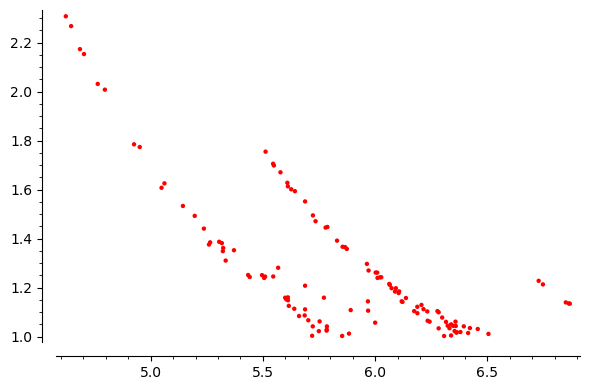

In [10]:
list_plot(Liste_nice_discri, color='red')   
# x is the root discriminant
# y is the bound

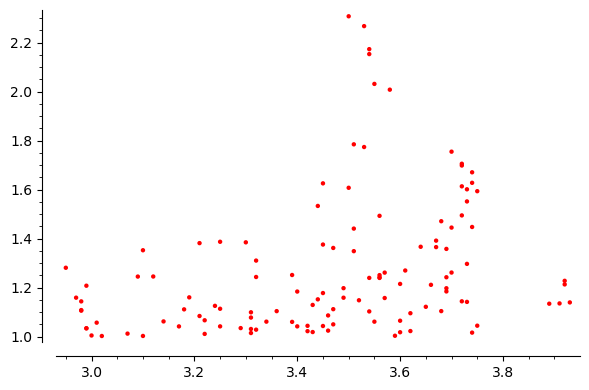

In [19]:
list_plot(Liste_nice_bounds, color='red')

In [11]:
for k in Liste_nice_fields:
    poly = k[0]
    J.<a> = NumberField(poly)
    print("for the field generated by", J.absolute_polynomial(), "we have ")
    optlam = optimi_lam1(Mes,0,J)
    print("a lower bound of",minorant_conducteur_lambda_nbfield(optlam,Mes,0,J)^(1/6))
    print("for a lambda of",optlam)
    listeofprimes = liste_premier_lambda(optlam)
    for p in listeofprimes:
        for pri in J.primes_above(p):
            fnu = pri.residue_class_degree()
            q = p^fnu
            m = 1
            while q^m < exp(optlam):
                print(float(m*math.log(q)/(optlam)),float(q^m))
                m += 1
    print()
                    

for the field generated by x^6 - x^5 + x^4 - 2*x^3 + 4*x^2 - 3*x + 1 we have 
a lower bound of 2.30692631360329
for a lambda of 3.50000000000000
0.9416676760012372 27.0
0.7328426735604393 13.0
0.7328426735604393 13.0
0.7328426735604393 13.0
0.8412682797618404 19.0
0.8412682797618404 19.0
0.8412682797618404 19.0
0.8412682797618404 19.0

for the field generated by x^6 - x^5 + 2*x^4 - 2*x^3 + 2*x^2 - 2*x + 1 we have 
a lower bound of 2.26682768778283
for a lambda of 3.53000000000000
0.9118628399060064 25.0
0.6792904455519467 11.0
0.6792904455519467 11.0
0.8026100124805149 17.0
0.8026100124805149 17.0
0.8341186909819949 19.0
0.8882419875153403 23.0
0.8882419875153403 23.0

for the field generated by x^6 - x^5 - x^4 + 2*x^3 - x + 1 we have 
a lower bound of 2.17290240324397
for a lambda of 3.54000000000000
0.6206849088520399 9.0
0.6773715459882407 11.0
0.8003427525582536 17.0
0.8003427525582536 17.0
0.8857328293585174 23.0
0.8857328293585174 23.0
0.9512135112956147 29.0
0.9512135112956147 2

a lower bound of 1.23975972223248
for a lambda of 3.56000000000000
0.19470426420223183 2.0
0.38940852840446366 4.0
0.5841127926066955 8.0
0.7788170568089273 16.0
0.9735213210111593 32.0
0.7788170568089273 16.0
0.9257968724731263 27.0
0.9257968724731263 27.0
0.7958464449596113 17.0
0.7958464449596113 17.0
0.8807568022272894 23.0
0.8807568022272894 23.0
0.9646031473272884 31.0
0.9646031473272884 31.0

for the field generated by x^6 - x^5 + x^4 - 2*x^3 + 3*x^2 - 2*x + 1 we have 
a lower bound of 1.24535965054860
for a lambda of 3.09000000000000
0.7110759149955405 9.0
0.5208536933443692 5.0
0.6297443848075449 7.0
0.7760178876370133 11.0

for the field generated by x^6 - 2*x^5 + 3*x^3 - 2*x - 1 we have 
a lower bound of 1.75479720441658
for a lambda of 3.70000000000000
0.869966439153568 25.0
0.869966439153568 25.0
0.869966439153568 25.0
0.76573333623141 17.0
0.76573333623141 17.0
0.7957943186936327 19.0
0.7957943186936327 19.0
0.8474308691700407 23.0
0.8474308691700407 23.0

for the field g

a lower bound of 1.04223776759592
for a lambda of 3.40000000000000
0.32312126137297353 3.0
0.6462425227459471 9.0
0.9693637841189204 27.0
0.4733640918923825 5.0
0.946728183784765 25.0
0.7543968698416286 13.0
0.8660114644607179 19.0
0.9222041811556324 23.0
0.9903811264666103 29.0
0.9903811264666103 29.0
0.9903811264666103 29.0

for the field generated by x^6 - x^5 - x^4 + 2*x^3 - x^2 + 1 we have 
a lower bound of 1.49478914974391
for a lambda of 3.72000000000000
0.5906517681011345 9.0
0.6445955034404225 11.0
0.7915158546146348 19.0
0.9051870510716332 29.0
0.9051870510716332 29.0
0.9051870510716332 29.0
0.9231148399153623 31.0
0.9231148399153623 31.0
0.9231148399153623 31.0
0.9982720609420187 41.0

for the field generated by x^6 - 2*x^4 - x^3 + 2*x^2 - 1 we have 
a lower bound of 1.47108400069829
for a lambda of 3.68000000000000
0.5970718960152772 9.0
0.6969971080058525 13.0
0.6969971080058525 13.0
0.9150260407571943 29.0
0.9150260407571943 29.0
0.9331486968709638 31.0
0.9331486968709638

a lower bound of 1.24226118410270
for a lambda of 3.56000000000000
0.9041786024910676 25.0
0.5466039744537398 7.0
0.673566087864711 11.0
0.673566087864711 11.0
0.8807568022272894 23.0

for the field generated by x^6 - 2*x^5 + 2*x^4 - x^3 - 1 we have 
a lower bound of 1.24255000711049
for a lambda of 3.69000000000000
0.4361620358900002 5.0
0.8723240717800004 25.0
0.8723240717800004 25.0
0.6951082269543462 13.0
0.8497274297910977 23.0
0.8497274297910977 23.0
0.8497274297910977 23.0
0.9125462953892887 29.0
0.930619838613861 31.0

for the field generated by x^6 - 2*x^5 + 3*x^4 - 2*x^3 - 1 we have 
a lower bound of 1.21536323467448
for a lambda of 3.60000000000000
0.5776226504666212 8.0
0.8941321735745005 25.0
0.5405305969598094 7.0
0.7870037066822826 17.0
0.8709706155358752 23.0
0.9538853345792077 31.0
0.9538853345792077 31.0
0.9538853345792077 31.0

for the field generated by x^6 - x - 1 we have 
a lower bound of 1.21166231752172
for a lambda of 3.66000000000000
0.4397371345448362 5.0
0.8

a lower bound of 1.03459262391207
for a lambda of 2.99000000000000
0.7348577181726489 9.0
0.7348577181726489 9.0
0.7348577181726489 9.0
0.801971663143268 11.0
0.801971663143268 11.0
0.8578425944687416 13.0
0.8578425944687416 13.0

for the field generated by x^6 - x^5 + 3*x^4 + 5*x^2 - 2*x + 1 we have 
a lower bound of 1.00508787356981
for a lambda of 3.00000000000000
0.6486367163517712 7.0
0.6486367163517712 7.0
0.8549831191538458 13.0
0.8549831191538458 13.0
0.8549831191538458 13.0
0.8549831191538458 13.0
0.8549831191538458 13.0
0.8549831191538458 13.0

for the field generated by x^6 - 3*x^5 + 4*x^4 - 2*x^3 - 2*x^2 + 2*x - 1 we have 
a lower bound of 1.05041277590982
for a lambda of 3.47000000000000
0.46381496035564845 5.0
0.9276299207112969 25.0
0.6910361016710002 11.0
0.6910361016710002 11.0
0.8164879954052495 17.0
0.9036006385962967 23.0
0.98962167276229 31.0

for the field generated by x^6 - x^5 + 2*x^4 - 2*x^3 - 1 we have 
a lower bound of 1.04450898919746
for a lambda of 3.42000

In [102]:
List_of_subfields2 = []
List_of_subfields3 = []
for k in Liste_nice_fields:
    poly = k[0]
    J.<a> = NumberField(poly)
    for subs in J.subfields():
        subfiel = subs[0]
        if subfiel.absolute_degree() == 2:
            polysub = subfiel.absolute_polynomial()
            List_of_subfields2 += [polysub]
        if subfiel.absolute_degree() == 3:
            polysub = subfiel.absolute_polynomial()
            List_of_subfields3 += [polysub]
            
print(List_of_subfields2)
print(List_of_subfields3)

[x^2 + x + 1, x^2 + 1, x^2 + x + 1, x^2 - 3*x + 8, x^2 - 5*x + 7, x^2 + x + 1, x^2 - x + 2, x^2 - 3*x + 9, x^2 - 4*x + 7, x^2 - x + 3, x^2 - 2*x + 5, x^2 - x + 1, x^2 - x + 1, x^2 + x + 1, x^2 - 3*x + 3, x^2 - 3*x + 10, x^2 + x - 1, x^2 + 2*x + 2, x^2 - x + 1, x^2 + 1, x^2 - x + 1, x^2 - 3*x + 3, x^2 - x - 1, x^2 + x + 1, x^2 + 3*x + 3, x^2 - 6*x + 11, x^2 - 2*x - 1, x^2 + x - 1, x^2 - x - 1, x^2 - x - 1, x^2 + 1, x^2 - x + 1, x^2 + 4*x - 1, x^2 - x - 1]
[x^3 - x - 1, x^3 - x^2 - 1, x^3 - 3*x^2 + 2*x - 1, x^3 - 3*x^2 + 2*x + 1, x^3 + x^2 + 7*x - 1, x^3 - x^2 + 2*x - 1, x^3 - x^2 - 2*x + 1, x^3 - 6*x^2 + 11*x - 7, x^3 - 3*x - 1, x^3 - x^2 + 3*x + 1, x^3 - x^2 + x + 1, x^3 - x^2 - x - 1, x^3 - 2*x^2 - x - 1, x^3 - x - 1, x^3 + 2*x^2 + x - 1, x^3 - 7*x^2 + 13*x - 2, x^3 - 7*x^2 + 15*x - 8, x^3 - 2*x^2 + 3*x - 1, x^3 - 7*x^2 + 16*x - 11, x^3 - 3*x^2 + 4*x - 3, x^3 - 3*x^2 + 4*x - 1, x^3 + 5*x^2 - x + 3, x^3 + 2*x^2 - 2, x^3 - x - 1, x^3 - 8*x^2 + 19*x - 13, x^3 - x^2 + 1, x^3 + x^2 - 1, x^

In [106]:
Listesofds = []
for pol in List_of_subfields2:
    K.<a> = NumberField(pol)
    disc = K.absolute_discriminant()
    if (disc % 4 == 0):
        Listesofds += [disc/4]
    else:
        Listesofds += [disc]

In [107]:
Listesofds

[-3,
 -1,
 -3,
 -23,
 -3,
 -3,
 -7,
 -3,
 -3,
 -11,
 -1,
 -3,
 -3,
 -3,
 -3,
 -31,
 5,
 -1,
 -3,
 -1,
 -3,
 -3,
 5,
 -3,
 -3,
 -2,
 2,
 5,
 5,
 5,
 -1,
 -3,
 5,
 5]

In [4]:
K.<a> = NumberField(x^7 - 2*x^6 + 3*x^5 - 2*x^4 + 2*x^3 + x^2 + x + 1)
optlam = optimi_lam1(Mes,0,K)
low_bound = minorant_conducteur_lambda_nbfield(optlam,Mes,0,K)^(1/7)

In [43]:
def goodapprox_Messtre_Somme_Frob(lam,MesF,K):
    Listeprime = liste_premier_lambda(lam)
    BigSomme = 0
    ListeFrob = []
    for p in Listeprime:
        for prims in K.primes_above(p):
            fnu = prims.residue_class_degree()
            frobenius = - 2 * floor(sqrt(p^fnu))
            BigSomme += Somme_Frob(p, fnu, lam, MesF, frobenius)
            ListeFrob += [(p,fnu,frobenius)]
    return (ListeFrob,2*BigSomme)


def goodapprox_minorant_nbfield_Frobenius(lam,MesF,rk,K):   # K nb field  
    n = K.absolute_degree()
    discri = K.absolute_discriminant()
    Listefrobs, MestreSomme = goodapprox_Messtre_Somme_Frob(lam,MesF,K)
    lowbound = lam * rk * Value_Phi_0(MesF) + n * Mlambda2(lam,MesF) + MestreSomme
    return Listefrobs , exp(lowbound)/(discri^2)


In [47]:
minorant_conducteur_lambda_nbfield(optlam,Mes,0,K)^(1/7)

0.476480115907539

In [49]:
goodapprox_minorant_nbfield_Frobenius(optlam,Mes,0,K)[1]^(1/7)

0.517264394830512